# Projeto Marinha do Brasil

## Laboratorio de Processamento de Sinais - UFRJ

#### Autor: Vinícius dos Santos Mello (viniciudsmello@poli.ufrj.br)

In [2]:
import os
import pickle
import numpy as np
import time
import multiprocessing 
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils
from keras.models import load_model
from keras import backend as K

from sklearn import preprocessing
from sklearn import metrics
from sklearn.externals import joblib

from Functions import FunctionsDataVisualization
from Functions import TrainParameters as trnparams
from Functions import TrainFunctions
from Functions import BalanceData

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

analysis_name = 'StackedAutoEncoder'
data_path = os.getenv('OUTPUTDATAPATH')
results_path = os.getenv('PACKAGE_NAME')

base_results_path = '%s/%s'%(results_path,analysis_name)
pict_results_path = '%s/pictures_files'%(base_results_path)
files_results_path = '%s/output_files'%(base_results_path)

# For multiprocessing purpose
num_processes = multiprocessing.cpu_count()

# Read data
# Check if LofarData has created...
m_time = time.time()

database = '4classes'
n_pts_fft = 1024
decimation_rate = 3
spectrum_bins_left = 400
development_flag = False
development_events = 400

if not os.path.exists('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                      (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left)):
    print 'No Files in %s/%s\n'%(data_path,database)
else:
    #Read lofar data
    [data,trgt,class_labels] = joblib.load('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                                           (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left))


    m_time = time.time()-m_time
    print 'Time to read data file: '+str(m_time)+' seconds'

    # correct format
    all_data = data
    all_trgt = trgt
    # Same number of events in each class
    qtd_events_biggest_class = 0
    biggest_class_label = ''

    for iclass, class_label in enumerate(class_labels):
        if sum(all_trgt==iclass) > qtd_events_biggest_class:
            qtd_events_biggest_class = sum(all_trgt==iclass)
            biggest_class_label = class_label
        print "Qtd event of %s is %i"%(class_label,sum(all_trgt==iclass))
    print "\nBiggest class is %s with %i events"%(biggest_class_label,qtd_events_biggest_class)

Time to import all libraries: 2.00271606445e-05 seconds
Time to read data file: 1.02904605865 seconds
Qtd event of 0 is 12939
Qtd event of 1 is 29352
Qtd event of 2 is 11510
Qtd event of 3 is 23760

Biggest class is 1 with 29352 events


# Balanceamento de Classes

In [19]:
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Process data
# imbalanced data to balanced data with random data creation of small classes
    
balanced_data = {}
balanced_trgt = {}

num_clusters = 20

silhouette_avg = np.zeros([len(class_labels), num_clusters-2])

results = np.zeros(4, dtype=object)

for iclass, class_label in enumerate(class_labels):
    print 'Clustering data of class %i'%iclass
    def Clusterize(iclusters):
        class_events = all_data[all_trgt==iclass,:]
        
        classBalance = BalanceData.DataCreator()
        classBalance.fit(class_events, iclusters)
        
        cluster_labels = classBalance.model.predict(class_events)
        
        return iclusters, silhouette_score(class_events, cluster_labels)
    
    p = multiprocessing.Pool(processes=num_processes)
    
    clusters = range(2,21)
    
    results[iclass] = p.map(Clusterize, clusters)
    
    p.close()
    p.join()


Clustering data of class 0
Clustering data of class 1
Clustering data of class 2
Clustering data of class 3


In [22]:
results[0] #iclass, icluster_result, cluster_id

(2, 0.02305948158127203)

In [20]:
# all_data = balanced_data
# all_trgt = balanced_trgt

## turn targets in sparse mode
# from keras.utils import np_utils
# trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))    
#         if len(balanced_data) == 0:
#             class_events = all_data[all_trgt==iclass,:]
            
#             classBalance = BalanceData.DataCreator()
#             classBalance.fit(class_events, iclusters)
            
#             balanced_data = classBalance.created_events(class_events, events)
#             balanced_trgt = (iclass)*np.ones(qtd_events_biggest_class)
#         else:
#             class_events = all_data[all_trgt==iclass,:]

#             classBalance = BalanceData.DataCreator()
#             classBalance.fit(class_events, iclusters)
            
#             created_events = classBalance.created_events(class_events, events)
            
#             balanced_data = np.append(balanced_data,created_events,axis=0)
#             balanced_trgt = np.append(balanced_trgt,
#                                       (iclass)*np.ones(created_events.shape[0]),axis=0)

In [2]:
%%time
# load parameters

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
#os.remove(trn_params_folder)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

n_folds = 2
CVO = trnparams.ClassificationFolds(folder=results_path,
                                    n_folds=n_folds,
                                    trgt=all_trgt,
                                    dev=development_flag, verbose=False)
print trn_params.get_params_str()

1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation
CPU times: user 5.36 ms, sys: 0 ns, total: 5.36 ms
Wall time: 9.25 ms


## Treinamento da 1ª Camada

In [51]:
%%time
# To train on multiple cores sweeping the number of folds
def trainFold(ifold):
    ineuron = 300
    return TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                            trgt=all_data,
                            ifold=ifold,
                            n_folds=n_folds, 
                            n_neurons=ineuron,
                            trn_params=trn_params, 
                            save_path=results_path,
                            dev=development_flag)
# To train on multiple cores sweeping the number of neurons
def trainNeuron(ineuron):
    for ifold in range(len(CVO)):
        TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                            trgt=all_data,
                            ifold=ifold,
                            n_folds=n_folds, 
                            n_neurons=ineuron,
                            trn_params=trn_params, 
                            save_path=results_path,
                            dev=development_flag)

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 7.15 µs


In [52]:
%time
p = multiprocessing.Pool(processes=num_processes+2)
start_time = time.time()
folds = range(len(CVO))
neurons = [0,100,200] + [250,300,350,400,450]
neurons.sort() # Train from 0 to 750
# To train on multiple cores sweeping the number of folds
results = p.map(trainFold, folds)

# To train on multiple cores sweeping the number of neurons
#results = p.map(trainNeuron, neurons)

p.close()
p.join()
end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
It took 0.106 seconds to perform the training


In [ ]:
print end_time/3600

# Análise da variação do número de Neurônios - 1ª Camada

Topology (1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation)


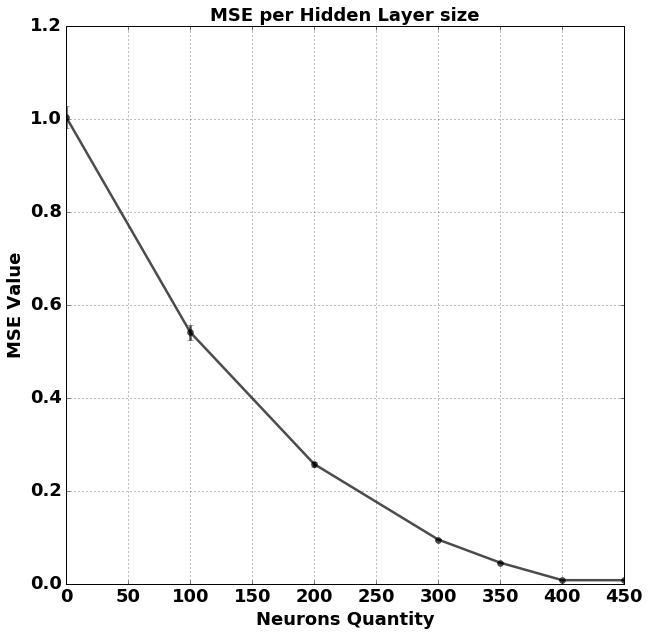

In [49]:
# Neuron variation x MSE

from sklearn import preprocessing
from sklearn import metrics

from keras.utils import np_utils
from keras.models import load_model

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

current_analysis = 'mse'

analysis_file_name='%s/%s/%s_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name, current_analysis)

#os.remove(analysis_file_name)

if not os.path.exists(analysis_file_name):
    trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)

    if not os.path.exists(trn_params_folder):
        trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                             hidden_activation='relu',
                                                             output_activation='linear',
                                                             n_epochs=500,
                                                             patience=30,
                                                             batch_size=256,
                                                             verbose=False)
        trn_params.save(trn_params_folder)
    else:
        trn_params = trnparams.NeuralClassificationTrnParams()
        trn_params.load(trn_params_folder)

    params_str = trn_params.get_params_str()
    n_folds = 2
    CVO = trnparams.ClassificationFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)

    neurons_mat = neurons
    neurons_mat.sort()
    
    mse_mat = np.zeros([n_folds,len(neurons_mat)])

    for ifold in range(len(CVO)):
        train_id, test_id = CVO[ifold]

        # normalize data based in train set
        if trn_params.params['norm'] == 'mapstd':
            scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapstd_rob':
            scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapminmax':
            scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

        norm_data = scaler.transform(all_data[test_id,:])

        for ineuron,neuron_value in enumerate(neurons_mat):     
            if neuron_value == 0:
                neuron_value = 1
            model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                                       model_prefix_str,
                                                       n_folds,
                                                       params_str,
                                                       neuron_value)

            if not development_flag:        
                file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
            else:
                file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
            print file_name
            if not os.path.exists(file_name):
                def trainFold(ifold):
                    ineuron = neuron_value
                    return TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                                            trgt=all_data,
                                            ifold=ifold,
                                            n_folds=n_folds, 
                                            n_neurons=ineuron,
                                            trn_params=trn_params, 
                                            save_path=results_path,
                                            dev=development_flag)
                
                p = multiprocessing.Pool(processes=num_processes)
                folds = range(len(CVO))
                results = p.map(trainFold, folds)
                p.close()
                p.join()
                
            model = load_model(file_name)
            output = model.predict(norm_data)
            mse = metrics.mean_squared_error(norm_data, output)
            mse_mat[ifold,ineuron] = mse
            
    joblib.dump([mse_mat,neurons_mat],analysis_file_name,compress=9)
else:
    [mse_mat,neurons_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig, ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1)

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

ax.errorbar(neurons_mat,np.mean(mse_mat,axis=0),
            np.std(mse_mat,axis=0),fmt='o-',
            color='k',alpha=0.7,linewidth=2.5)

ax.set_title('MSE per Hidden Layer size',fontsize=18,weight='bold')
ax.set_xlabel('Neurons Quantity',fontsize=18,weight='bold')
ax.set_ylabel('MSE Value',fontsize=18,weight='bold') 
ax.grid()
#Save the figure
file_name = pict_results_path+'/'+current_analysis+'_first_layer_'+trn_params.get_params_str()+'.pdf'
plt.savefig(file_name)
print "Topology (%s)"%trn_params.get_params_str()

# Autocorrelação para Entrada x Saída - 1ª camada

Topology (1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation)


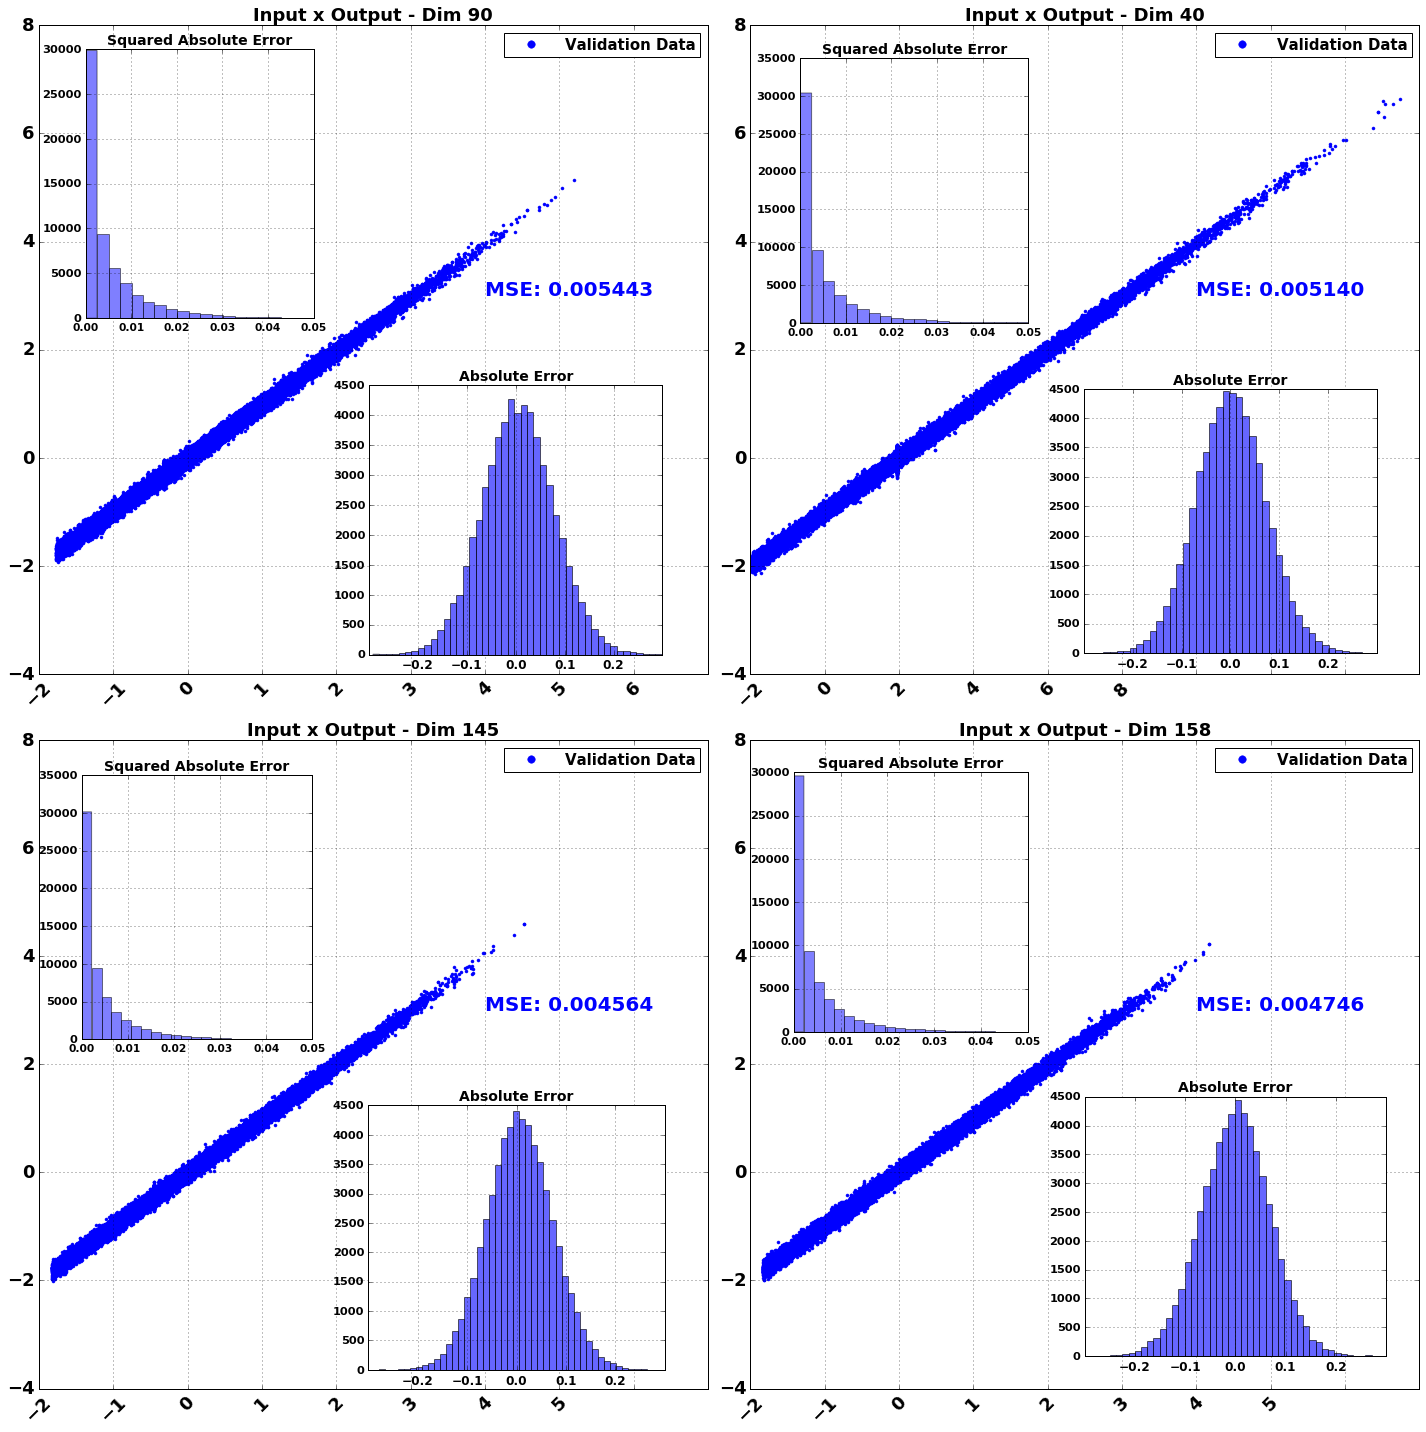

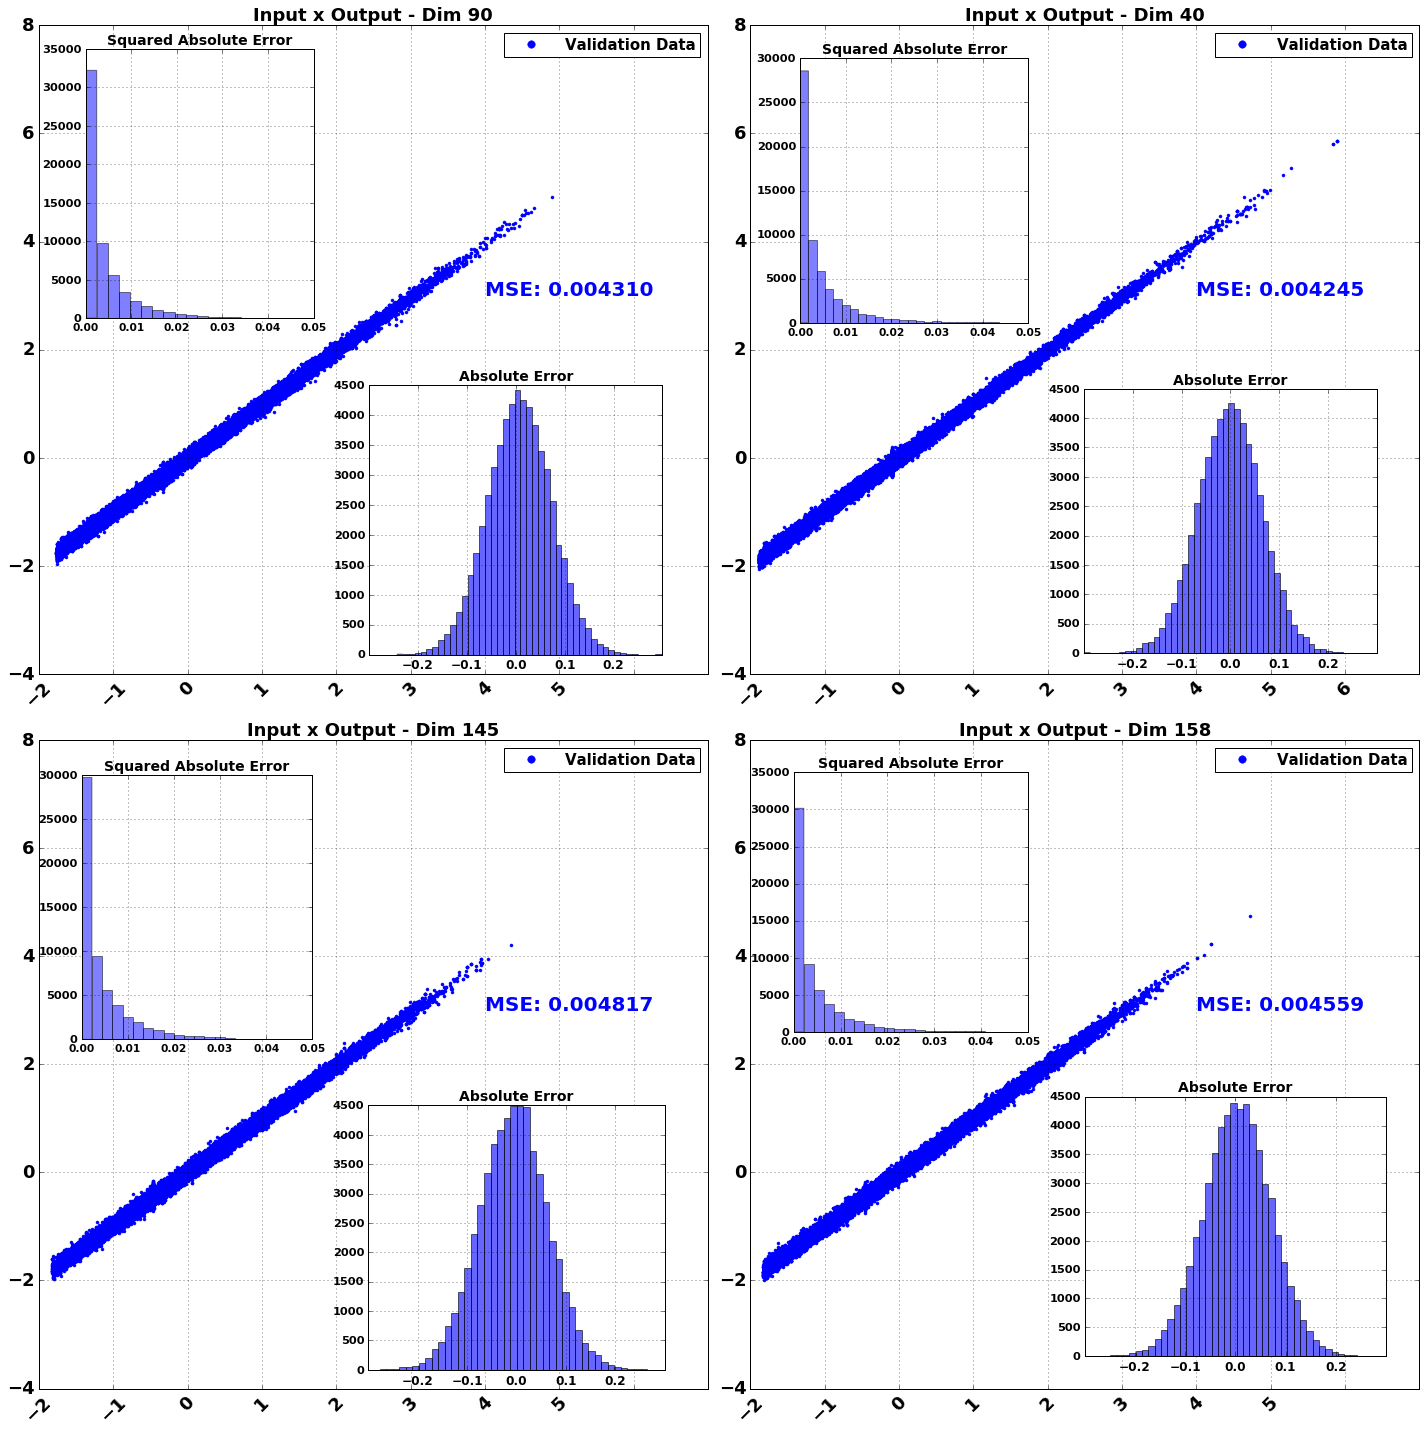

In [42]:
# Analysis of Reconstruction Input x Output

import matplotlib.pyplot as plt
%matplotlib inline  

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

current_analysis = 'reconstruction_inputxoutput'

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3

# Number of neurons at first layer
ineuron = 400

models = {}
outputs = {}
mean = {}
indexes = {}

# Load Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)

if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='relu',
                                                         output_activation='linear',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()

for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data)
    norm_data = norm_data[test_id,:]
    
    if ifold == 0:
        diffSquared = np.zeros([len(CVO),norm_data.shape[0],norm_data.shape[1]])
        
    # Get the model file
    model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                               model_prefix_str,
                                               n_folds,
                                               params_str,
                                               ineuron)

    if not development_flag:        
        file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)

    if not os.path.exists(file_name):
        def trainFold(ifold):
            return TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                                    trgt=all_data,
                                    ifold=ifold,
                                    n_folds=n_folds, 
                                    n_neurons=ineuron,
                                    trn_params=trn_params, 
                                    save_path=results_path,
                                    dev=development_flag)
        
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    models[ifold]  = load_model(file_name)
    outputs[ifold] = models[ifold].predict(norm_data) 

    diffSquared[ifold] = np.power((norm_data - outputs[ifold]), 2) 

mean = np.mean(np.mean(diffSquared, axis=0), axis=0)
indexes = np.argsort(mean)[::-1]

for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data)
    norm_data = norm_data[test_id,:]
    
    points = norm_data.shape[0]
    # Number of dimensions to analyse (even number is better!)
    num_dim = 4
    fig, m_ax = plt.subplots(figsize=(20,20),nrows=2, ncols=2)
    for choose_index in range(num_dim):
        ax = plt.subplot(2,2,choose_index+1)
        ax.plot(norm_data[:,indexes[choose_index]][0],
                outputs[ifold][:,indexes[choose_index]][0],
                "b.", label='Validation Data', markersize=15)
        ax.plot(norm_data[:,indexes[choose_index]][:points], 
                outputs[ifold][:,indexes[choose_index]][:points],
                "b.")
        
        plt.tight_layout()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title('Input x Output - Dim %i'%(indexes[choose_index]),fontsize=18, fontweight='bold')  
        ax.set_xlim(-2, 7)
        ax.set_ylim(-4, 8)
        handles, labels = ax.get_legend_handles_labels()
        plt.legend()
        plt.grid()    
        
        # Small plot
        rect = [0.065, 0.55, 0.35, 0.4]
        ax1 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
        
        eq_reconstruction = np.power((norm_data[:,indexes[choose_index]] - outputs[ifold][:,indexes[choose_index]]), 2)

        mq_bins = np.linspace(np.min(eq_reconstruction), np.max(eq_reconstruction), 50)
  
        n, bins, patches = ax1.hist(eq_reconstruction,bins=mq_bins,
                                    fc="b",
                                    alpha=0.5, normed=0)
        ax1.set_xlim(0, 0.05)
        ax1.set_title("Squared Absolute Error",fontsize=14, fontweight='bold')
        ax1.grid() 
        
        # Small plot
        rect = [0.5, 0.05, 0.45, 0.4]
        ax2 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
        
        e_reconstruction = (norm_data[:,indexes[choose_index]] - outputs[ifold][:,indexes[choose_index]])

        m_bins = np.linspace(np.min(e_reconstruction), np.max(e_reconstruction), 50)
     
        n, bins, patches = ax2.hist(e_reconstruction,bins=m_bins,
                                    fc="b",
                                    alpha=0.6, normed=0)
        ax2.grid()
        ax2.set_title("Absolute Error",fontsize=14, fontweight='bold')
        ax2.set_xlim(-0.3,0.3) 
        
        ax.legend(handles, labels, ncol=1, loc='upper right')
        plt.legend()
        
        mse = metrics.mean_squared_error(norm_data[:,indexes[choose_index]], outputs[ifold][:,indexes[choose_index]])
        ax.text(4, 3, 'MSE: %f'%mse, style='normal',fontsize=20, color='blue',
        bbox={'alpha':0.0, 'pad':10})
        
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_first_layer_400x%i_neurons_%i_fold_'%(ineuron,ifold)+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)
print "Topology (%s)"%trn_params.get_params_str()

# Análise LOFAR para reconstrução da 1ª Camada

In [ ]:
# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

# LOFARGram for reconstructed input with lines
current_analysis = 'LOFARGram_reconstruction_first_layer'

# Choose num of neurons
ineuron = 400

for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data)

    # Get the model file
    model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                               model_prefix_str,
                                               n_folds,
                                               params_str,
                                               ineuron)

    if not development_flag:        
        file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
    model = load_model(file_name)
    all_output = model.predict(norm_data)

    m_fontsize = 15

    fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,10))
    for iclass, class_label in enumerate(class_labels):
        ax = plt.subplot(2,2,iclass+1)
        plt.title('Lofar Analysis for Class %s'%(class_label), fontsize= m_fontsize, fontweight="bold")

        if iclass > 1:
            plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
        if ((iclass == 0) or (iclass==2)):
            plt.ylabel('Time (seconds)', fontsize= m_fontsize, fontweight="bold")

        plt.imshow(all_output[all_trgt==iclass,:],
               cmap="jet",extent=[1, 400, all_output[all_trgt==iclass,:].shape[0],1],
               aspect="auto")
        plt.xticks(np.linspace(0,400,9),rotation=45)
        cbar = plt.colorbar()
        plt.clim(-2,9)
        #if ((iclass == 1) or (iclass==3)):
        cbar.ax.set_ylabel('dB',fontweight='bold') 
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_%i'%ifold+'_fold'+'_%i'%ineuron+'_neurons_'+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)

In [ ]:
# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

# LOFARGram for reconstructed input with lines
current_analysis = 'LOFARGram_reconstruction_x_original_first_layer'

# Choose num of neurons
ineuron = 400

neurons_str = str(all_data.shape[1]) + 'x' + str(ineuron)

# Choose class
iclass = 1

for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data)

    # Get the model file
    model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                               model_prefix_str,
                                               n_folds,
                                               params_str,
                                               ineuron)

    if not development_flag:        
        file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
    model = load_model(file_name)
    all_output = model.predict(norm_data)

    m_fontsize = 12

    fig, subplot_array = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
    for i in range(2):
        ax = plt.subplot(1,2,i+1)
        if i == 0:
            plt.imshow(norm_data[all_trgt==iclass,:],
               cmap="jet",extent=[1, 400, norm_data[all_trgt==iclass,:].shape[0],1],
               aspect="auto")
            plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
            plt.title('Lofar Analysis for Original Data of %s'%(class_labels[iclass]), fontsize= m_fontsize, fontweight="bold")
        if (i == 1):
            plt.ylabel('Time (seconds)', fontsize= m_fontsize, fontweight="bold")
            plt.imshow(all_output[all_trgt==iclass,:],
               cmap="jet",extent=[1, 400, all_output[all_trgt==iclass,:].shape[0],1],
               aspect="auto")
            plt.title('Lofar Analysis for Reconstructed Data of %s'%(class_labels[iclass]), fontsize= m_fontsize, fontweight="bold")
       
        plt.xticks(np.linspace(0,400,9),rotation=45)
        cbar = plt.colorbar()
        plt.clim(-2,9)
        #if ((iclass == 1) or (iclass==3)):
        cbar.ax.set_ylabel('dB',fontweight='bold') 
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_%i'%ifold+'_fold'+'_%s'%neurons_str+'_neurons_%i_class_'%(1+iclass)+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)

In [ ]:
# LOFARGram for reconstructed input with lines
current_analysis = 'LOFARGram_reconstruction_first_layer'

# Choose num of lines to plot
points = 20

# Choose num of neurons
ineuron = 400

for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data)

    # Get the model file
    model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                               model_prefix_str,
                                               n_folds,
                                               params_str,
                                               ineuron)

    if not development_flag:        
        file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
    model = load_model(file_name)
    all_output = model.predict(norm_data)

    m_fontsize = 15

    fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,10))
    for iclass, class_label in enumerate(class_labels):
        ax = plt.subplot(2,2,iclass+1)
        plt.title('Lofar Analysis for Reconstruction of Class %s'%(class_label), fontsize= m_fontsize, fontweight="bold")

        if iclass > 1:
            plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
        if ((iclass == 0) or (iclass==2)):
            plt.ylabel('Time (seconds)', fontsize= m_fontsize, fontweight="bold")

        # Plot lines at frequencies with high errors
        for index in indexes[:points]:
            plt.axvline(index, color='r', alpha=0.7)

        plt.imshow(all_output[all_trgt==iclass,:],
               cmap="jet",extent=[1, 400, all_output[all_trgt==iclass,:].shape[0],1],
               aspect="auto")
        plt.xticks(np.linspace(0,400,9),rotation=45)
        cbar = plt.colorbar()
        plt.clim(-2,9)
        #if ((iclass == 1) or (iclass==3)):
        cbar.ax.set_ylabel('dB',fontweight='bold') 

    #Save the figure
    file_name = pict_results_path+'/'+current_analysis+'_%i'%points+'_points'+'_%i'%ifold+'_fold'+'_%i'%ineuron+'_neurons_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print "Topology (%s)"%trn_params.get_params_str()

In [ ]:
# LOFARGram for original input
fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,10))
for iclass, class_label in enumerate(class_labels):
    ax = plt.subplot(2,2,iclass+1)
    plt.title('Lofar Analysis for Class %s'%(class_label), fontsize= m_fontsize, fontweight="bold")

    if iclass > 1:
        plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
    if ((iclass == 0) or (iclass==2)):
        plt.ylabel('Time (seconds)', fontsize= m_fontsize, fontweight="bold")

    plt.imshow(norm_data[all_trgt==iclass,:],
           cmap="jet",extent=[1, 400, norm_data[all_trgt==iclass,:].shape[0],1],
           aspect="auto")
    plt.xticks(np.linspace(0,400,9),rotation=45)
    cbar = plt.colorbar()
    plt.clim(-2,9)
    #if ((iclass == 1) or (iclass==3)):
    cbar.ax.set_ylabel('dB',fontweight='bold') 
#Save the figure
file_name = pict_results_path+'/LOFARGram_original.pdf'
plt.savefig(file_name)

## Análise de Classificação - 1º Camada

In [ ]:
%time
# Load Parameters
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
#os.remove(trn_params_folder)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear', # For AutoEncoder
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

In [ ]:
%time
def SAEClassificationtrainFold(ifold):
    return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                          trgt=all_trgt,
                                          ifold=ifold,
                                          n_folds=n_folds, 
                                          hidden_neurons=[400],
                                          trn_params=trn_params, 
                                          save_path=results_path,
                                          dev=development_flag)

In [ ]:
%time

p = multiprocessing.Pool(processes=num_processes)
start_time = time.time()

folds = range(len(CVO))
# To train on multiple cores sweeping the number of folds
results = p.map(SAEClassificationtrainFold, folds)

# To train on multiple cores sweeping the number of neurons
#results = p.map(trainNeuron, neurons)

p.close()
p.join()

end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

In [ ]:
# Mean Squared Error x Epochs
%matplotlib inline  
import matplotlib.pyplot as plt

current_analysis = 'mse'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

hidden_neurons = [400]

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()

# plot train updates
for ifold in range(len(CVO)):
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    plt.rc('legend',**{'fontsize':15})
    plt.rc('font', weight='bold')
    
    fig1 = plt.figure(figsize=(10,6))
    
    neurons_str = '400'
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_trn_desc.jbl'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_trn_desc_dev.jbl'%(model_str,ifold)
        print load_file_name
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    [trn_desc] = joblib.load(load_file_name)

    l1 = plt.plot(trn_desc['epochs'],
                  trn_desc['loss'],color=[0,0,1],
                  linewidth=2.5,linestyle='solid',label='Train Perf.')
    l2 = plt.plot(trn_desc['epochs'],
                  trn_desc['val_loss'],color=[1,0,0],
                  linewidth=2.5,linestyle='dashed',label='Test Perf.')
    cost = ''
    cost = 'MSE'

    plt.grid(True)
    plt.xlabel("# Epochs",fontsize=18,fontweight='bold')
    plt.ylabel(cost,fontsize=18,fontweight='bold')
    plt.title(cost+" vs #Epochs",fontsize=18,fontweight='bold')
    plt.legend()
    #Save the figure
    file_name = pict_results_path+'/Classification_(%s)_'%neurons_str\
        +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print 'Topolgy (%s)'%topology

In [ ]:
# Confusion Matrix

%matplotlib inline  
from sklearn import preprocessing

current_analysis = 'confusion_matrix'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

hidden_neurons = [400]
analysis_full_data = False

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.set_aspect(1)

    from sklearn.metrics import confusion_matrix

    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    if analysis_full_data:
        norm_data = scaler.transform(all_data)
        norm_trgt = all_trgt
    else: 
        norm_data = scaler.transform(all_data[test_id, :])
        norm_trgt = all_trgt[test_id]
        
    neurons_str = '400'
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
    
    all_output = np.argmax(output,axis=1)
    cm = confusion_matrix(norm_trgt, all_output)
    cm_normalized = 100.*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im =ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

    width, height = cm_normalized.shape

    for x in xrange(width):
        for y in xrange(height):
            if cm_normalized[x][y] < 50.:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center')
            else:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center',color='white')

    ax.set_title('Confusion Matrix',fontweight='bold',fontsize=15)
    fig.colorbar(im)
    tick_marks = np.arange(len(labels))
    ax.xaxis.set_ticks(tick_marks)
    ax.xaxis.set_ticklabels(labels)

    ax.yaxis.set_ticks(tick_marks)
    ax.yaxis.set_ticklabels(labels)

    ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
    ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
    
    #Save the figure
    if analysis_full_data:
        file_name = pict_results_path+'/Classification_(%s)_all_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    else: 
        file_name = pict_results_path+'/Classification_(%s)_test_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print 'Topology (%s)'%topology
if analysis_full_data:
    print 'Analysis in All Data'

In [ ]:
# Histogram

%matplotlib inline  
from sklearn import preprocessing
import matplotlib.pyplot as plt

current_analysis = 'histogram'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

# Choose Topology
hidden_neurons = [400]
analysis_full_data = False
neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    if analysis_full_data:
        norm_data = scaler.transform(all_data)
        norm_trgt = all_trgt
    else: 
        norm_data = scaler.transform(all_data[test_id, :])
        norm_trgt = all_trgt[test_id]
    
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
    # Check if the topology has already been trained    
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   
    from sklearn.neighbors import KernelDensity

    m_bins = np.linspace(-0.5, 1.5, 50)

    m_colors = ['b', 'r', 'g', 'y']
    
    for i_target in range(trgt_sparse[test_id].shape[1]):
        for i_output in range(output.shape[1]):
            subplot_id = output.shape[1]*i_target+i_output
            m_pts = output[norm_trgt==i_target,i_output]

            n, bins, patches = ax[i_target,i_output].hist(m_pts,bins=m_bins,
                                                          fc=m_colors[i_target],
                                                          alpha=0.8, normed=0)

            if i_output == 0:
                ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                                 fontweight='bold',fontsize=15)
            if i_target == 3:
                ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                                 fontweight='bold',fontsize=15)
            ax[i_target,i_output].grid()
    
    #Save the figure
    if analysis_full_data:
        file_name = pict_results_path+'/Classification_(%s)_all_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    else: 
        file_name = pict_results_path+'/Classification_(%s)_test_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print 'Topology (%s)'%topology
if analysis_full_data:
    print 'Analysis in All Data'

In [ ]:
# Kernel Density

%matplotlib inline  
from sklearn import preprocessing

current_analysis = 'kernel_density'

hidden_neurons = [400]
analysis_full_data = False

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    if analysis_full_data:
        norm_data = scaler.transform(all_data)
        norm_trgt = all_trgt
    else: 
        norm_data = scaler.transform(all_data[test_id, :])
        norm_trgt = all_trgt[test_id]
    
    neurons_str = '400'
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name 
    # Check if the topology has already been trained    
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   
    from sklearn.neighbors import KernelDensity

    m_bins = np.linspace(-0.5, 1.5,100)

    m_colors = ['b', 'r', 'g', 'y']

    kernel = 'gaussian' # other kernels: 'gaussian', 'tophat', 
                        #'epanechnikov', 'exponential', 'linear', 'cosine'
    for i_target in range(trgt_sparse[test_id].shape[1]):
        for i_output in range(output.shape[1]):
            subplot_id = output.shape[1]*i_target+i_output
            m_pts = output[norm_trgt==i_target,i_output]

            kde = KernelDensity(kernel=kernel,algorithm='auto',
                                bandwidth=0.5).fit(m_pts[:, np.newaxis])
            log_dens_x = kde.score_samples(m_bins[:, np.newaxis])
            ax[i_target,i_output].plot(m_bins, np.exp(log_dens_x),
                                       color=m_colors[i_target],linewidth=2.0)
            if i_output == 0:
                ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                                 fontweight='bold',fontsize=15)
            if i_target == 3:
                ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                                 fontweight='bold',fontsize=15)
            ax[i_target,i_output].grid()
    
    #Save the figure
    if analysis_full_data:
        file_name = pict_results_path+'/Classification_(%s)_all_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    else: 
        file_name = pict_results_path+'/Classification_(%s)_test_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print 'Topology (%s)'%topology
if analysis_full_data:
    print 'Analysis in All Data'

In [ ]:
# Classification Report

# Choose Topology
hidden_neurons = [250]
analysis_full_data = True

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)
params_str = trn_params.get_params_str()

neurons_str = '400'
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])

print "Results for (%s) neurons (%s)"%(neurons_str, params_str)

if analysis_full_data:
    print 'Analysis in All Data'
    
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    
    if analysis_full_data:
        norm_data = scaler.transform(all_data)
        norm_trgt = all_trgt
        norm_trgt_sparse = trgt_sparse
    else: 
        norm_data = scaler.transform(all_data[test_id, :])
        norm_trgt = all_trgt[test_id]
        norm_trgt_sparse = trgt_sparse[test_id]
    
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name
    # Check if the topology has already been trained    
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   
    num_classes = len(class_labels.keys())
    
    efficiency = metrics.recall_score(norm_trgt_sparse, np.round(output), average=None)
    sp_index = np.sum(efficiency)/num_classes * np.power(np.prod(efficiency), 1/num_classes)
    sp_index = np.sqrt(sp_index)
    
    precision = metrics.precision_score(norm_trgt_sparse, np.round(output), average=None)
    f1_score = metrics.f1_score(norm_trgt_sparse, np.round(output), average=None)
    print '\tPrecision\tEfficiency\tF1_Score'
    for iclass in range(num_classes):
        print '%s:\t%f\t%f\t%f\n'%(class_labels[iclass], precision[iclass], efficiency[iclass],f1_score[iclass])
    print 'SP index: %f\n'%sp_index

# Treinamento da 2ª Camada

In [55]:
%%time

hidden_neurons = [300]

# To train on multiple cores sweeping the number of folds
def trainFold(ifold):
    ineuron = 200
    return TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                                trgt=all_data,
                                ifold=ifold,
                                n_folds=n_folds, 
                                n_neurons=ineuron,
                                trn_params=trn_params, 
                                save_path=results_path,
                                dev=development_flag,
                                layer = 2,
                                hidden_neurons = hidden_neurons)
    
# To train on multiple cores sweeping the number of neurons
def trainNeuron(ineuron):
    for ifold in range(len(CVO)):
        TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                            trgt=all_data,
                            ifold=ifold,
                            n_folds=n_folds, 
                            n_neurons=ineuron,
                            trn_params=trn_params, 
                            save_path=results_path,
                            dev=development_flag,
                            layer = 2,
                            hidden_neurons = hidden_neurons)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11 µs


In [56]:
%time
p = multiprocessing.Pool(processes=num_processes)
start_time = time.time()
folds = range(len(CVO))
neurons = [1,100,200,250,300] # Train from 0 to 300
# To train on multiple cores sweeping the number of folds
#results = p.map(trainFold, folds)

# To train on multiple cores sweeping the number of neurons
results = p.map(trainNeuron, neurons)

p.close()
p.join()
end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
It took 0.106 seconds to perform the training


   # Análise da variação do número de neurônios - 2ª Camada

[*] Loading topology 400x300x1
[*] Loading topology 400x300x100
[*] Loading topology 400x300x200
[*] Loading topology 400x300x250
[*] Loading topology 400x300x300
[*] Loading topology 400x300x1
[*] Loading topology 400x300x100
[*] Loading topology 400x300x200
[*] Loading topology 400x300x250
[*] Loading topology 400x300x300
Topology (1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation)


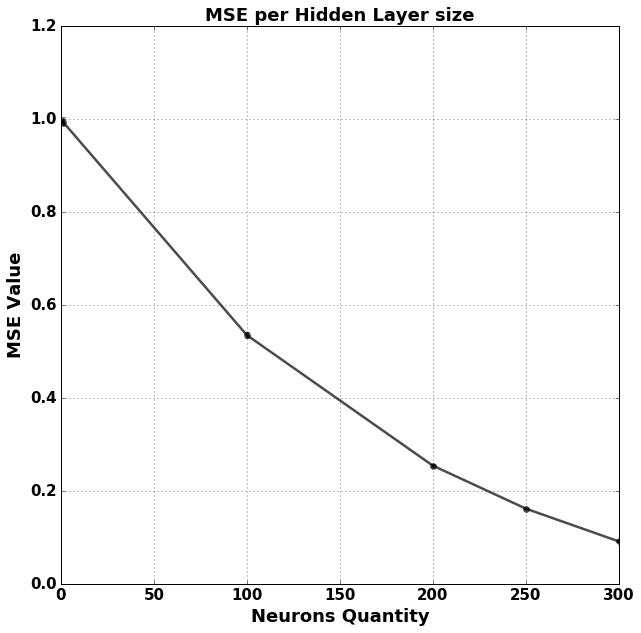

In [57]:
# Neuron variation x MSE

from sklearn import preprocessing
from sklearn import metrics

from keras.utils import np_utils
from keras.models import load_model

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

current_analysis = 'mse'

hidden_neurons = [300]
layer = 2

neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
analysis_file_name='%s/%s/%s_%s_second_layer_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name, current_analysis)

if os.path.exists(analysis_file_name):
    os.remove(analysis_file_name)

if not os.path.exists(analysis_file_name):
    trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)

    if not os.path.exists(trn_params_folder):
        trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                             hidden_activation='tanh',
                                                             output_activation='linear',
                                                             n_epochs=500,
                                                             patience=30,
                                                             batch_size=256,
                                                             verbose=False)
        trn_params.save(trn_params_folder)
    else:
        trn_params = trnparams.NeuralClassificationTrnParams()
        trn_params.load(trn_params_folder)

    params_str = trn_params.get_params_str()
    n_folds = 2
    CVO = trnparams.ClassificationFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)

    neurons_mat = neurons
    neurons_mat.sort()
    
    mse_mat = np.zeros([n_folds,len(neurons_mat)])

    for ifold in range(len(CVO)):
        train_id, test_id = CVO[ifold]

        # normalize data based in train set
        if trn_params.params['norm'] == 'mapstd':
            scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapstd_rob':
            scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapminmax':
            scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

        norm_data = scaler.transform(all_data)
        norm_data = norm_data[test_id,:]
        
        for ineuron,neuron_value in enumerate(neurons_mat):     
            if neuron_value == 0:
                neuron_value = 1
            print '[*] Loading topology 400x%ix%i'%(hidden_neurons[0], neuron_value)
            # First Layer
            previous_model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                                                prefix_str,
                                                                n_folds,
                                                                params_str,
                                                                hidden_neurons[0])

            if not development_flag:
                file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
            else:
                file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
                
            # Get the first layer weights
            first_layer_model = load_model(file_name)
            encoder_first_layer = first_layer_model.layers[0].get_weights()
            decoder_first_layer = first_layer_model.layers[2].get_weights()

            # Second Layer
            previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%i_neurons'%(save_path,analysis_str,
                                                                prefix_str,
                                                                n_folds,
                                                                params_str,
                                                                hidden_neurons[0],
                                                                neuron_value)

            if not development_flag:
                file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
            else:
                file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
                
            # Get the second layer projection of data
            second_layer_model = load_model(file_name)
            encoder_second_layer = second_layer_model.layers[0].get_weights()
            decoder_second_layer = second_layer_model.layers[2].get_weights()

            model = Sequential()
            # Encoder
            model.add(Dense(hidden_neurons[0], input_dim=norm_data.shape[1], weights=encoder_first_layer, trainable=False))
            model.add(Activation(trn_params.params['hidden_activation']))
            model.add(Dense(neuron_value, weights=encoder_second_layer, trainable=False))
            model.add(Activation(trn_params.params['hidden_activation']))
            # Decoder
            model.add(Dense(hidden_neurons[0], weights=decoder_second_layer, trainable=False))
            model.add(Activation(trn_params.params['output_activation']))
            model.add(Dense(norm_data.shape[1], weights=decoder_first_layer, trainable=False))
            model.add(Activation(trn_params.params['output_activation'], trainable=False))
            #model.summary()
            output = model.predict(norm_data)
            
            mse = metrics.mean_squared_error(norm_data, output)
            mse_mat[ifold,ineuron] = mse
            
    joblib.dump([mse_mat,neurons_mat],analysis_file_name,compress=9)
else:
    [mse_mat,neurons_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig, ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1)

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

ax.errorbar(neurons_mat,np.mean(mse_mat,axis=0),
            np.std(mse_mat,axis=0),fmt='o-',
            color='k',alpha=0.7,linewidth=2.5)

ax.set_title('MSE per Hidden Layer size',fontsize=18,weight='bold')
ax.set_xlabel('Neurons Quantity',fontsize=18,weight='bold')
ax.set_ylabel('MSE Value',fontsize=18,weight='bold') 
ax.grid()
#Save the figure
file_name = pict_results_path+'/'+current_analysis+'_second_layer_'+trn_params.get_params_str()+'.pdf'
plt.savefig(file_name)
print "Topology (%s)"%trn_params.get_params_str()


# Autocorrelação Entrada x Saída - 2ª Camada

Fold 0
[*] Loading topology 400x300x200
Fold 1
[*] Loading topology 400x300x200
Topology (1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation)


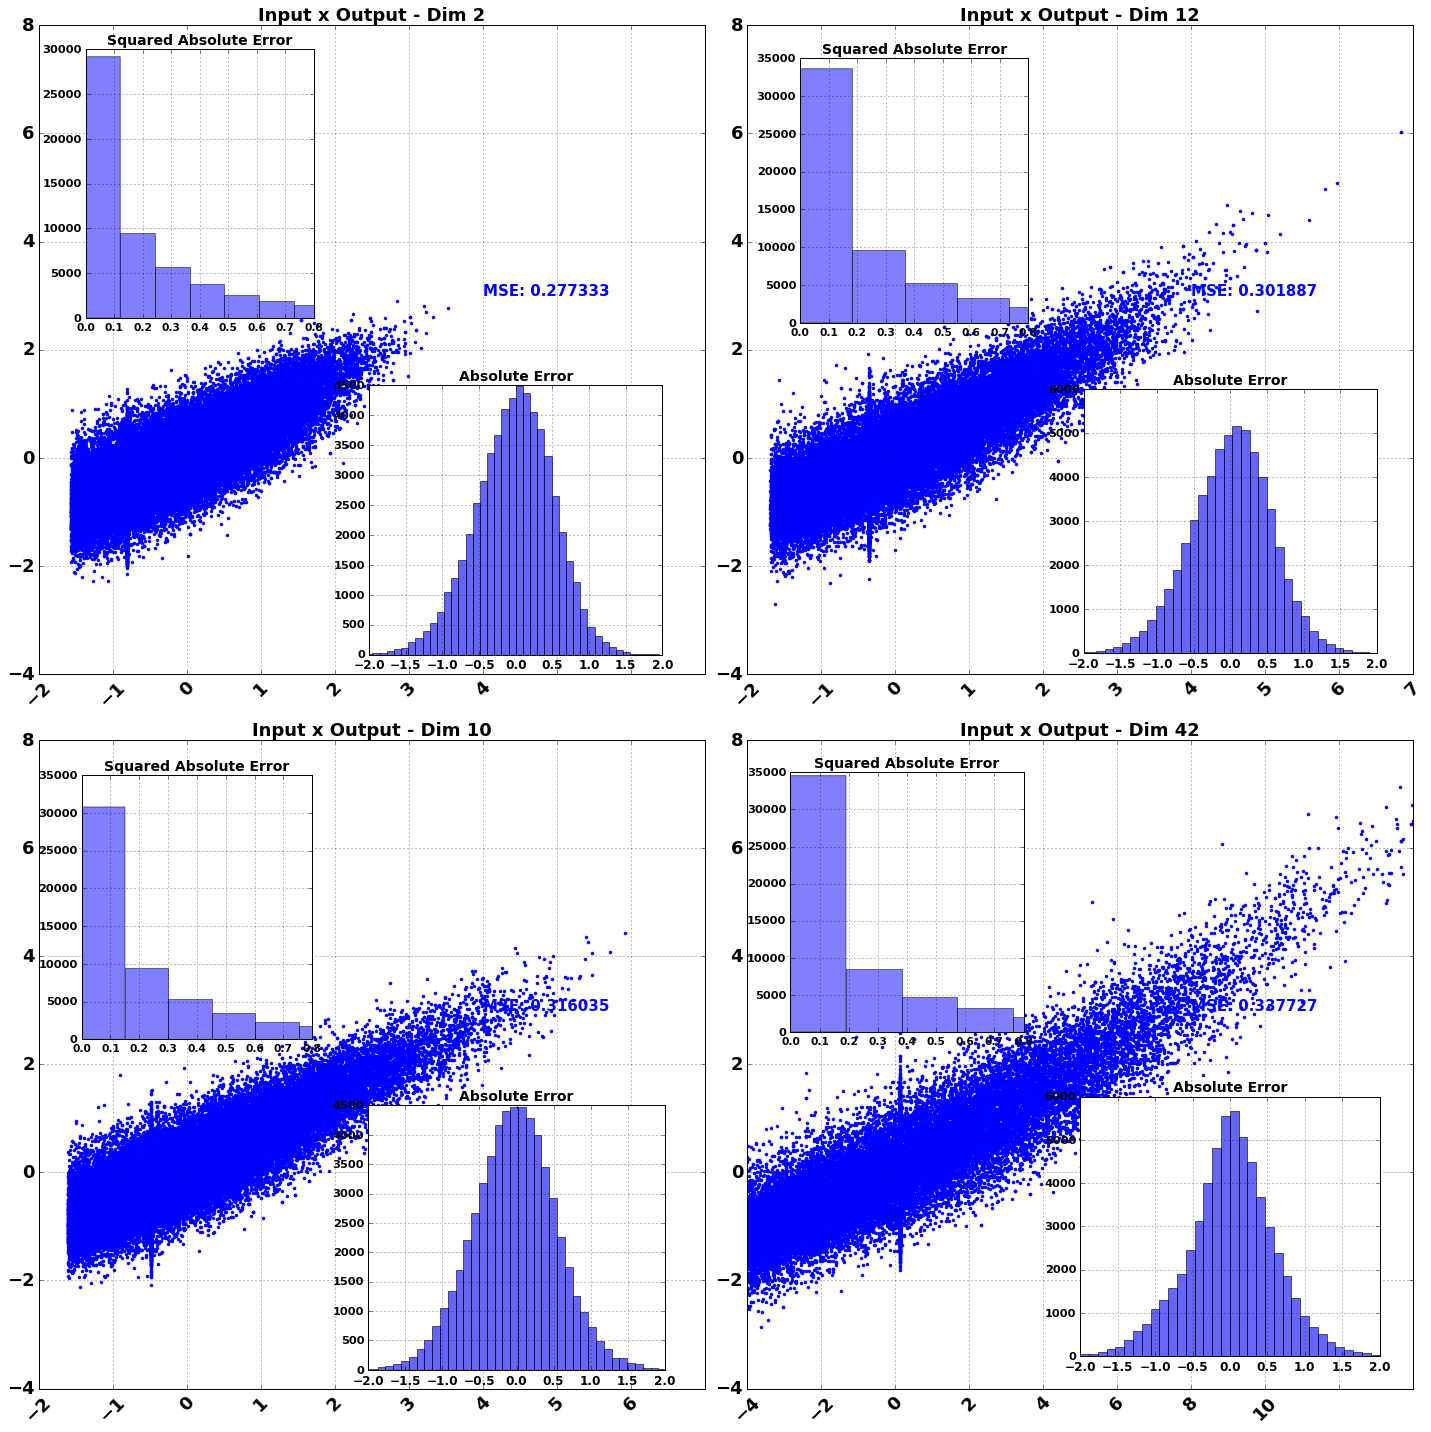

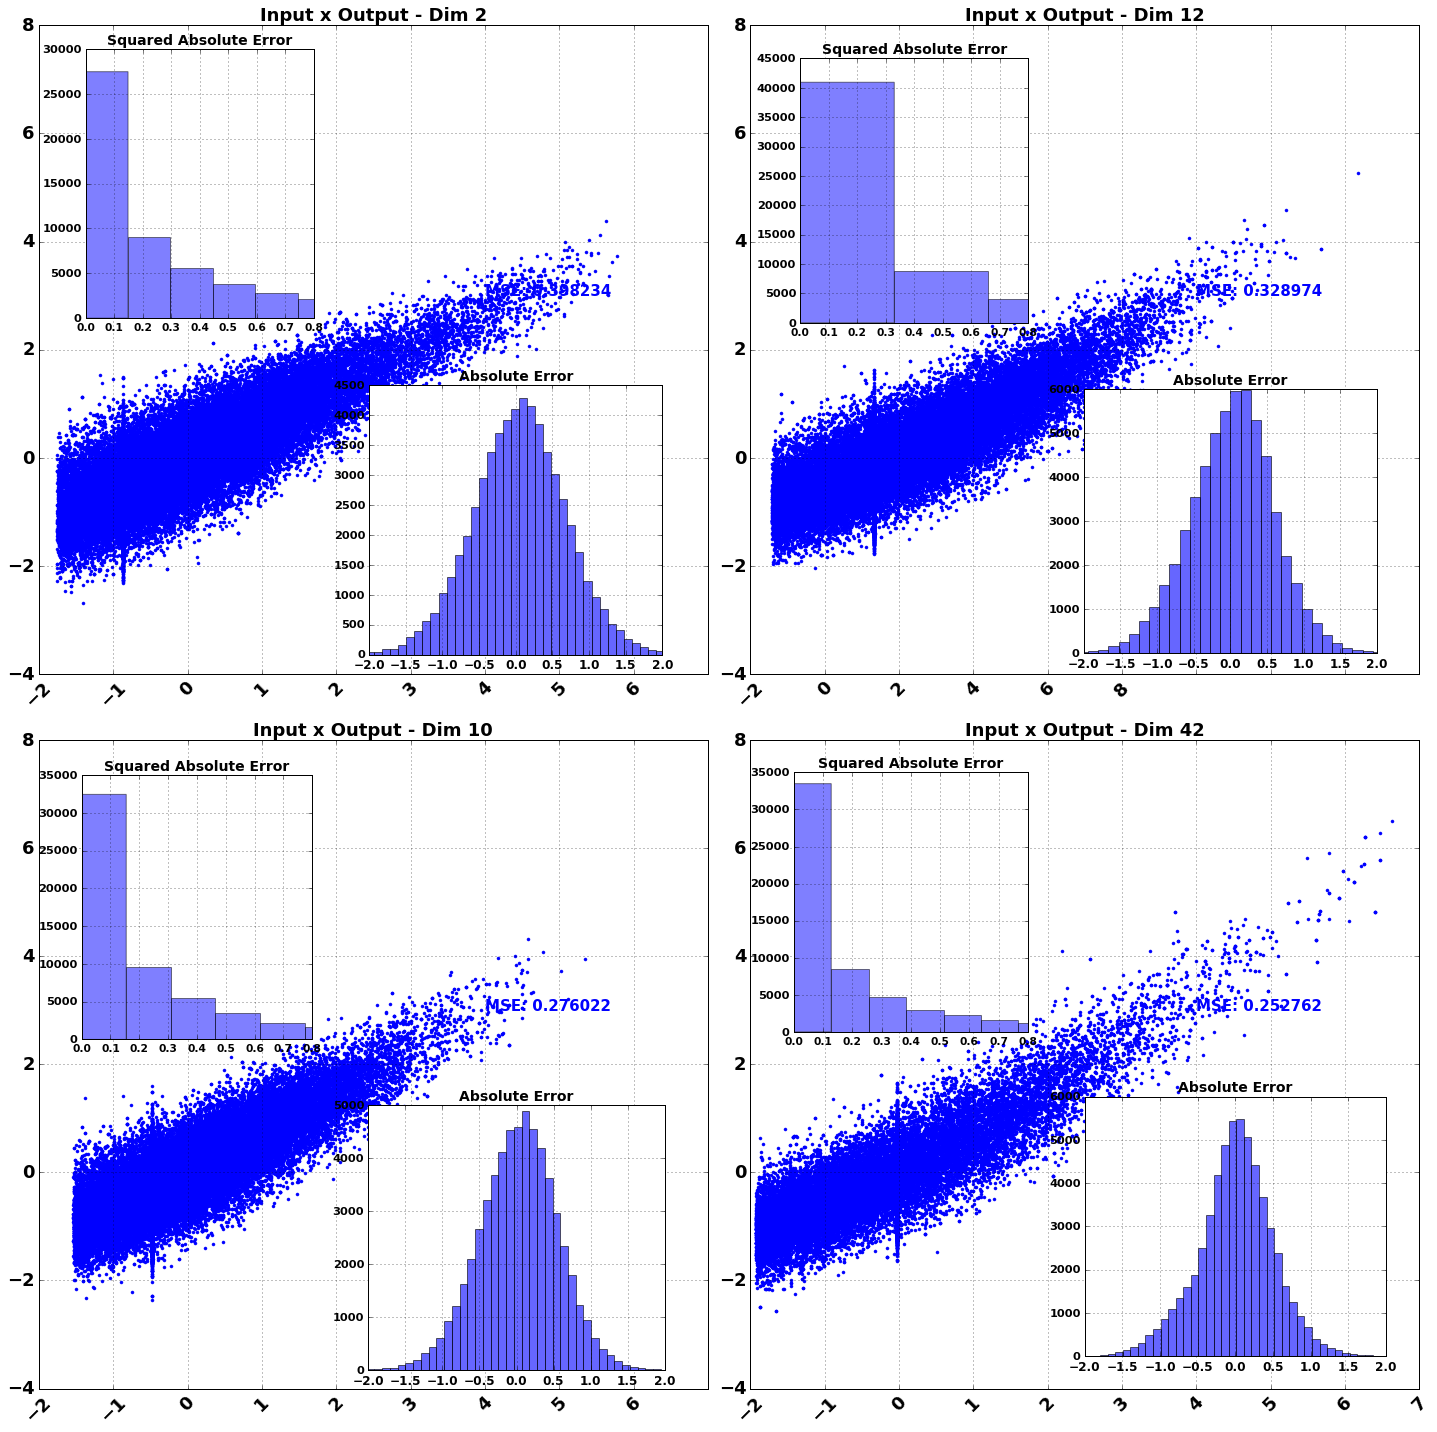

In [59]:
# Analysis of Reconstruction Input x Output

import matplotlib.pyplot as plt
%matplotlib inline  

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

current_analysis = 'reconstruction_inputxoutput'

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3

# Topology
hidden_neurons = [300, 200]

neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)

models = {}
outputs = {}
mean = {}
indexes = {}

# Load Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)

if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='relu',
                                                         output_activation='linear',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()

for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    print 'Fold %i'%ifold
    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data)
    norm_data = norm_data[test_id,:]
    print '[*] Loading topology %s'%neurons_str
    # First Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the first layer weights
    first_layer_model = load_model(file_name)
    encoder_first_layer = first_layer_model.layers[0].get_weights()
    decoder_first_layer = first_layer_model.layers[2].get_weights()
    
    # Second Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the second layer projection of data
    second_layer_model = load_model(file_name)
    encoder_second_layer = second_layer_model.layers[0].get_weights()
    decoder_second_layer = second_layer_model.layers[2].get_weights()
    
    model = Sequential()
    # Encoder
    model.add(Dense(hidden_neurons[0], input_dim=norm_data.shape[1], weights=encoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    model.add(Dense(hidden_neurons[1], weights=encoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    # Decoder
    model.add(Dense(hidden_neurons[0], weights=decoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    model.add(Dense(norm_data.shape[1], weights=decoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation'], trainable=False))
    #model.summary()
    
    all_output = model.predict(norm_data)
    
    outputs[ifold] = all_output
    diffSquared[ifold] = np.power((norm_data - outputs[ifold]), 2) 

mean = np.mean(np.mean(diffSquared, axis=0), axis=0)
indexes = np.argsort(mean)[::-1]

for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data)
    norm_data = norm_data[test_id,:]
    
    points = norm_data.shape[0]
    # Number of dimensions to analyse (even number is better!)
    num_dim = 4
    fig, m_ax = plt.subplots(figsize=(20,20),nrows=2, ncols=2)
    for choose_index in range(num_dim):
        ax = plt.subplot(2,2,choose_index+1)
        ax.plot(norm_data[:,indexes[choose_index]][:points], outputs[ifold][:,indexes[choose_index]][:points],"b.")
        plt.tight_layout()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title('Input x Output - Dim %i'%(indexes[choose_index]),fontsize=18, fontweight='bold')  
        ax.set_xlim(-2, 7)
        ax.set_ylim(-4, 8)
        handles, labels = ax.get_legend_handles_labels()
        plt.legend()
        plt.grid()    
        
        # Small plot
        rect = [0.065, 0.55, 0.35, 0.4]
        ax1 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
        
        eq_reconstruction = np.power((norm_data[:,indexes[choose_index]] - outputs[ifold][:,indexes[choose_index]]), 2)

        mq_bins = np.linspace(np.min(eq_reconstruction), np.max(eq_reconstruction), 50)
  
        n, bins, patches = ax1.hist(eq_reconstruction,bins=mq_bins,
                                    fc="b",
                                    alpha=0.5, normed=0)
        ax1.set_xlim(0,0.8)
        ax1.set_title("Squared Absolute Error",fontsize=14, fontweight='bold')
        ax1.grid() 
        
        # Small plot
        rect = [0.5, 0.05, 0.45, 0.4]
        ax2 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
        
        e_reconstruction = (norm_data[:,indexes[choose_index]] - outputs[ifold][:,indexes[choose_index]])

        m_bins = np.linspace(np.min(e_reconstruction), np.max(e_reconstruction), 50)
     
        n, bins, patches = ax2.hist(e_reconstruction,bins=m_bins,
                                    fc="b",
                                    alpha=0.6, normed=0)
        ax2.grid()
        ax2.set_title("Absolute Error",fontsize=14, fontweight='bold')
        ax2.set_xlim(-2,2) 
        
        plt.legend()
        
        mse = metrics.mean_squared_error(norm_data[:,indexes[choose_index]], outputs[ifold][:,indexes[choose_index]])
        ax.text(4, 3, 'MSE: %f'%mse, style='normal',fontsize=15, color='blue',
        bbox={'alpha':0.0, 'pad':10})
         
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_second_layer_%s_neurons_%i_fold_'%(neurons_str,ifold)+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)
print "Topology (%s)"%trn_params.get_params_str()

# Análise LOFAR para reconstrução da 2ª Camada

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

# LOFARGram for reconstructed input
current_analysis = 'LOFARGram_reconstruction_second_layer'

# Choose num of neurons
hidden_neurons = [400, 300]

# Create a string like InputDimension x FirstLayerDimension x ... x OutputDimension
neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
neurons_str = neurons_str + 'x' + str(all_data.shape[1])

for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data)
    
    # First Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the first layer weights
    first_layer_model = load_model(file_name)
    encoder_first_layer = first_layer_model.layers[0].get_weights()
    decoder_first_layer = first_layer_model.layers[2].get_weights()
    
    # Second Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the second layer projection of data
    second_layer_model = load_model(file_name)
    encoder_second_layer = second_layer_model.layers[0].get_weights()
    decoder_second_layer = second_layer_model.layers[2].get_weights()
    
    model = Sequential()
    # Encoder
    model.add(Dense(hidden_neurons[0], input_dim=norm_data.shape[1], weights=encoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    model.add(Dense(hidden_neurons[1], weights=encoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    # Decoder
    model.add(Dense(hidden_neurons[0], weights=decoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    model.add(Dense(norm_data.shape[1], weights=decoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation'], trainable=False))
    #model.summary()
    all_output = model.predict(norm_data)
    
    m_fontsize = 15

    fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,10))
    for iclass, class_label in enumerate(class_labels):
        ax = plt.subplot(2,2,iclass+1)
        plt.title('Lofar Analysis for Class %s'%(class_label), fontsize= m_fontsize, fontweight="bold")

        if iclass > 1:
            plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
        if ((iclass == 0) or (iclass==2)):
            plt.ylabel('Time (seconds)', fontsize= m_fontsize, fontweight="bold")

        plt.imshow(all_output[all_trgt==iclass,:],
               cmap="jet",extent=[1, 400, all_output[all_trgt==iclass,:].shape[0],1],
               aspect="auto")
        plt.xticks(np.linspace(0,400,9),rotation=45)
        cbar = plt.colorbar()
        plt.clim(-2,9)
        #if ((iclass == 1) or (iclass==3)):
        cbar.ax.set_ylabel('dB',fontweight='bold') 
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_%s'%neurons_str+'_%i'%ifold+'_fold'+'_'+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)

In [ ]:
# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'

# LOFARGram for reconstructed input with lines
current_analysis = 'LOFARGram_reconstruction_x_original_second_layer'

# Choose num of neuronshidden_neuronsurons = [400, 300]

neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)

# Choose class
iclass = 1

params_str = trn_params.get_params_str()

for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data)
    norm_data = norm_data[test_id,:]
    # First Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the first layer weights
    first_layer_model = load_model(file_name)
    encoder_first_layer = first_layer_model.layers[0].get_weights()
    decoder_first_layer = first_layer_model.layers[2].get_weights()
    
    # Second Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the second layer projection of data
    second_layer_model = load_model(file_name)
    encoder_second_layer = second_layer_model.layers[0].get_weights()
    decoder_second_layer = second_layer_model.layers[2].get_weights()
    
    model = Sequential()
    # Encoder
    model.add(Dense(hidden_neurons[0], input_dim=norm_data.shape[1], weights=encoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    model.add(Dense(hidden_neurons[1], weights=encoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    # Decoder
    model.add(Dense(hidden_neurons[0], weights=decoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    model.add(Dense(norm_data.shape[1], weights=decoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation'], trainable=False))
    #model.summary()
    all_output = model.predict(norm_data)

    m_fontsize = 12

    fig, subplot_array = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
    for i in range(2):
        ax = plt.subplot(1,2,i+1)
        if i == 0:
            plt.imshow(norm_data[all_trgt==iclass,:],
               cmap="jet",extent=[1, 400, norm_data[all_trgt==iclass,:].shape[0],1],
               aspect="auto")
            plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
            plt.title('Lofar Analysis for Original Data of %s'%(class_labels[iclass]), fontsize= m_fontsize, fontweight="bold")
        if (i == 1):
            plt.ylabel('Time (seconds)', fontsize= m_fontsize, fontweight="bold")
            plt.imshow(all_output[all_trgt==iclass,:],
               cmap="jet",extent=[1, 400, all_output[all_trgt==iclass,:].shape[0],1],
               aspect="auto")
            plt.title('Lofar Analysis for Reconstructed Data of %s'%(class_labels[iclass]), fontsize= m_fontsize, fontweight="bold")
       
        plt.xticks(np.linspace(0,400,9),rotation=45)
        cbar = plt.colorbar()
        plt.clim(-2,9)
        #if ((iclass == 1) or (iclass==3)):
        cbar.ax.set_ylabel('dB',fontweight='bold') 
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_%i'%ifold+'_fold'+'_%s'%neurons_str+'_neurons_%i_class_'%(1+iclass)+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)

# Treinamento de Classificação - 2ª camada

In [ ]:
%time
# Load Parameters
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
#os.remove(trn_params_folder)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear', # For AutoEncoder
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

In [62]:
%time
from Functions import TrainFunctions
def SAEClassificationtrainFold(ifold):
    return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                          trgt=all_trgt,
                                          ifold=ifold,
                                          n_folds=n_folds, 
                                          hidden_neurons=(300,200),
                                          trn_params=trn_params, 
                                          save_path=results_path,
                                          dev=development_flag)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 5.96 µs


In [63]:
%time

p = multiprocessing.Pool(processes=num_processes)
start_time = time.time()

folds = range(len(CVO))
# To train on multiple cores sweeping the number of folds
results = p.map(SAEClassificationtrainFold, folds)

# To train on multiple cores sweeping the number of neurons
#results = p.map(trainNeuron, neurons)

p.close()
p.join()

end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
It took 0.218 seconds to perform the training


# Análise de Classificação - 2ª camada

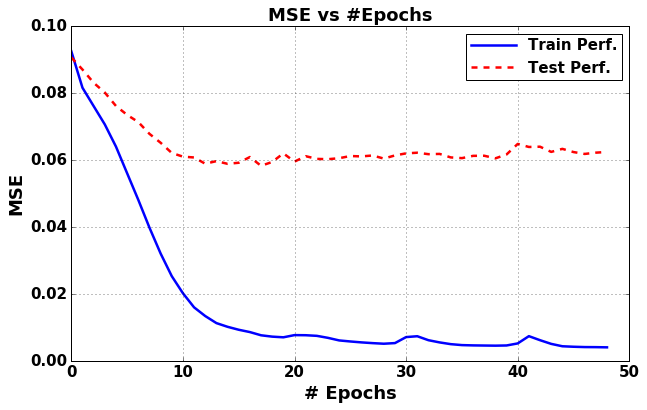

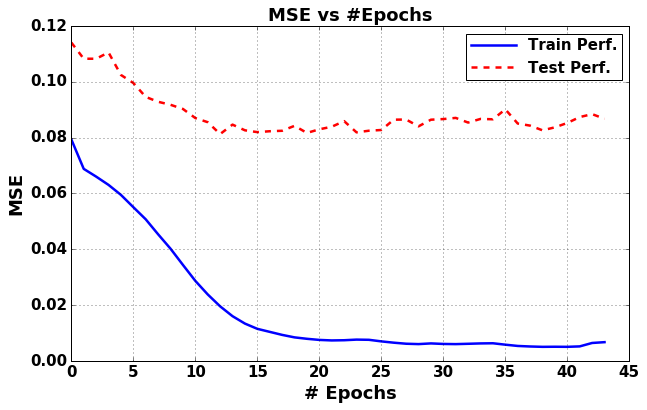

In [64]:
# Mean Squared Error x Epochs
%matplotlib inline  
import matplotlib.pyplot as plt

current_analysis = 'mse'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

hidden_neurons = [300,200]

# Parameters
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()

# plot train updates
for ifold in range(len(CVO)):
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    plt.rc('legend',**{'fontsize':15})
    plt.rc('font', weight='bold')
    
    fig1 = plt.figure(figsize=(10,6))
    
    neurons_str = '400'
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    model_str = '%s/%s/Classification_(%s)_%s_%i_folds_%s'%(save_path,analysis_str,
                                                            neurons_str,
                                                            prefix_str, n_folds,
                                                            params_str)

    if not development_flag:        
        load_file_name = '%s_fold_%i_trn_desc.jbl'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_trn_desc_dev.jbl'%(model_str,ifold)
        print load_file_name
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    [trn_desc] = joblib.load(load_file_name)

    l1 = plt.plot(trn_desc['epochs'],
                  trn_desc['loss'],color=[0,0,1],
                  linewidth=2.5,linestyle='solid',label='Train Perf.')
    l2 = plt.plot(trn_desc['epochs'],
                  trn_desc['val_loss'],color=[1,0,0],
                  linewidth=2.5,linestyle='dashed',label='Test Perf.')
    cost = ''
    cost = 'MSE'

    plt.grid(True)
    plt.xlabel("# Epochs",fontsize=18,fontweight='bold')
    plt.ylabel(cost,fontsize=18,fontweight='bold')
    plt.title(cost+" vs #Epochs",fontsize=18,fontweight='bold')
    plt.legend()
    #Save the figure
    file_name = pict_results_path+'/Classification_(%s)_'%neurons_str\
        +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)

Topology (Classification_(400x300x200x4)_RawData_2_folds_1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation)


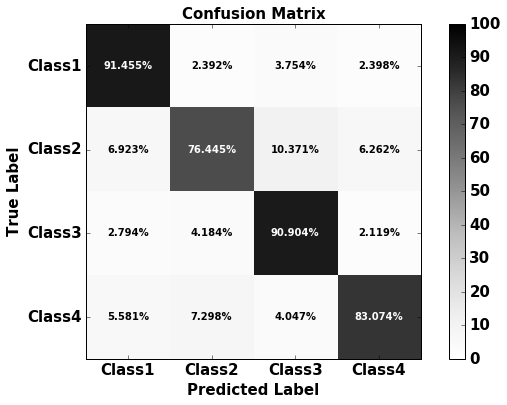

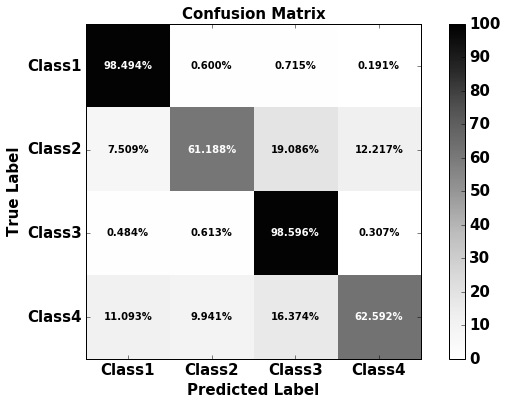

In [65]:
# Confusion Matrix

%matplotlib inline  
from sklearn import preprocessing
import matplotlib.pyplot as plt

current_analysis = 'confusion_matrix'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path


hidden_neurons = [300, 200]

analysis_full_data = False

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear', # for autoencoders
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.set_aspect(1)

    from sklearn.metrics import confusion_matrix

    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
    
    if analysis_full_data:
        norm_data = scaler.transform(all_data)
        norm_trgt = all_trgt
    else: 
        norm_data = scaler.transform(all_data[test_id, :])
        norm_trgt = all_trgt[test_id]
    
    neurons_str = str(all_data.shape[1])
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
    
    all_output = np.argmax(output,axis=1)
    cm = confusion_matrix(norm_trgt, all_output)
    cm_normalized = 100.*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im =ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

    width, height = cm_normalized.shape

    for x in xrange(width):
        for y in xrange(height):
            if cm_normalized[x][y] < 50.:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center')
            else:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center',color='white')

    ax.set_title('Confusion Matrix',fontweight='bold',fontsize=15)
    fig.colorbar(im)
    tick_marks = np.arange(len(labels))
    ax.xaxis.set_ticks(tick_marks)
    ax.xaxis.set_ticklabels(labels)

    ax.yaxis.set_ticks(tick_marks)
    ax.yaxis.set_ticklabels(labels)

    ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
    ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
    
    #Save the figure
    if analysis_full_data:
        file_name = pict_results_path+'/Classification_(%s)_all_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    else: 
        file_name = pict_results_path+'/Classification_(%s)_test_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print 'Topology (%s)'%topology
if analysis_full_data:
    print 'Analysis in All Data'

In [ ]:
# Histogram

%matplotlib inline  
from sklearn import preprocessing

current_analysis = 'histogram'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

# Choose Topology
hidden_neurons = [400,300]
analysis_full_data = False

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    if analysis_full_data:
        norm_data = scaler.transform(all_data)
        norm_trgt = all_trgt
    else: 
        norm_data = scaler.transform(all_data[test_id, :])
        norm_trgt = all_trgt[test_id]
    
    neurons_str = str(all_data.shape[1])
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
    # Check if the topology has already been trained    
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   
    from sklearn.neighbors import KernelDensity

    m_bins = np.linspace(-0.5, 1.5, 50)

    m_colors = ['b', 'r', 'g', 'y']
    
    for i_target in range(trgt_sparse[test_id].shape[1]):
        for i_output in range(output.shape[1]):
            subplot_id = output.shape[1]*i_target+i_output
            m_pts = output[norm_trgt==i_target,i_output]

            n, bins, patches = ax[i_target,i_output].hist(m_pts,bins=m_bins,
                                                          fc=m_colors[i_target],
                                                          alpha=0.8, normed=0)

            if i_output == 0:
                ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                                 fontweight='bold',fontsize=15)
            if i_target == 3:
                ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                                 fontweight='bold',fontsize=15)
            ax[i_target,i_output].grid()
    
    #Save the figure
    if analysis_full_data:
        file_name = pict_results_path+'/Classification_(%s)_all_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    else: 
        file_name = pict_results_path+'/Classification_(%s)_test_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print 'Topology (%s)'%topology
if analysis_full_data:
    print 'Analysis in All Data'

In [ ]:
# Kernel Density

%matplotlib inline  
from sklearn import preprocessing
import matplotlib.pyplot as plt

current_analysis = 'kernel_density'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

# Choose Topology
hidden_neurons = [400,300]
analysis_full_data = False

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    if analysis_full_data:
        norm_data = scaler.transform(all_data)
        norm_trgt = all_trgt
    else: 
        norm_data = scaler.transform(all_data[test_id, :])
        norm_trgt = all_trgt[test_id]
    
    neurons_str = str(all_data.shape[1])
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name 
    # Check if the topology has already been trained    
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   
    from sklearn.neighbors import KernelDensity

    m_bins = np.linspace(-0.5, 1.5,100)

    m_colors = ['b', 'r', 'g', 'y']

    kernel = 'gaussian' # other kernels: 'gaussian', 'tophat', 
                        #'epanechnikov', 'exponential', 'linear', 'cosine'
    for i_target in range(trgt_sparse[test_id].shape[1]):
        for i_output in range(output.shape[1]):
            subplot_id = output.shape[1]*i_target+i_output
            m_pts = output[norm_trgt==i_target,i_output]

            kde = KernelDensity(kernel=kernel,algorithm='auto',
                                bandwidth=0.5).fit(m_pts[:, np.newaxis])
            log_dens_x = kde.score_samples(m_bins[:, np.newaxis])
            ax[i_target,i_output].plot(m_bins, np.exp(log_dens_x),
                                       color=m_colors[i_target],linewidth=2.0)
            if i_output == 0:
                ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                                 fontweight='bold',fontsize=15)
            if i_target == 3:
                ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                                 fontweight='bold',fontsize=15)
            ax[i_target,i_output].grid()
    
    #Save the figure
    if analysis_full_data:
        file_name = pict_results_path+'/Classification_(%s)_all_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    else: 
        file_name = pict_results_path+'/Classification_(%s)_test_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print 'Topology (%s)'%topology
if analysis_full_data:
    print 'Analysis in All Data'

In [66]:
# Classification Report

current_analysis = 'report'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

# Choose Topology
hidden_neurons = [300,200]
analysis_full_data = False

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)
params_str = trn_params.get_params_str()

neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])

print "Results for (%s) neurons (%s)"%(neurons_str, params_str)
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data[test_id,:])
    
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name
    # Check if the topology has already been trained    
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   
    num_classes = len(class_labels.keys())
    
    efficiency = metrics.recall_score(trgt_sparse[test_id], np.round(output), average=None)
    sp_index = np.sum(efficiency)/num_classes * np.power(np.prod(efficiency), 1/num_classes)
    sp_index = np.sqrt(sp_index)
    
    precision = metrics.precision_score(trgt_sparse[test_id], np.round(output), average=None)
    f1_score = metrics.f1_score(trgt_sparse[test_id], np.round(output), average=None)
    print '\tPrecision\tEfficiency\tF1_Score'
    for iclass in range(num_classes):
        print '%s:\t%f\t%f\t%f\n'%(class_labels[iclass], precision[iclass], efficiency[iclass],f1_score[iclass])
    print 'SP index: %f\n'%sp_index
   

Results for (400x300x200x4) neurons (1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation)
	Precision	Efficiency	F1_Score
Class1:	0.871508	0.911829	0.891212

Class2:	0.846398	0.764445	0.803337

Class3:	0.833396	0.909035	0.869574

Class4:	0.885146	0.830744	0.857083

SP index: 0.924128

	Precision	Efficiency	F1_Score
Class1:	0.853868	0.984601	0.914586

Class2:	0.845813	0.611883	0.710078

Class3:	0.731584	0.985963	0.839936

Class4:	0.831162	0.625920	0.714086

SP index: 0.895596



# Treinamento da 3ª Camada

In [67]:
%%time

hidden_neurons = [300, 200]

# To train on multiple cores sweeping the number of folds
def trainFold(ifold):
    ineuron = 200
    return TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                                trgt=all_data,
                                ifold=ifold,
                                n_folds=n_folds, 
                                n_neurons=ineuron,
                                trn_params=trn_params, 
                                save_path=results_path,
                                dev=development_flag,
                                layer = 3,
                                hidden_neurons = hidden_neurons)
    
# To train on multiple cores sweeping the number of neurons
def trainNeuron(ineuron):
    for ifold in range(len(CVO)):
        TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                            trgt=all_data,
                            ifold=ifold,
                            n_folds=n_folds, 
                            n_neurons=ineuron,
                            trn_params=trn_params, 
                            save_path=results_path,
                            dev=development_flag,
                            layer = 3,
                            hidden_neurons = hidden_neurons)
print trn_params.get_params_str()

1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation
CPU times: user 344 µs, sys: 25 µs, total: 369 µs
Wall time: 209 µs


In [68]:
%time
p = multiprocessing.Pool(processes=num_processes)
start_time = time.time()

folds = range(len(CVO))
neurons = [1,50,100,150,200] # Train from 0 to 300

# To train on multiple cores sweeping the number of folds
#results = p.map(trainFold, folds)

# To train on multiple cores sweeping the number of neurons
results = p.map(trainNeuron, neurons)

p.close()
p.join()
end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
Neuron: 200 - Fold 1 of 2 Folds -  Init 1 of 1 Inits
Neuron: 100 - Fold 1 of 2 Folds -  Init 1 of 1 Inits
Neuron: 50 - Fold 1 of 2 Folds -  Init 1 of 1 Inits
Neuron: 150 - Fold 1 of 2 Folds -  Init 1 of 1 Inits
Neuron: 1 - Fold 1 of 2 Folds -  Init 1 of 1 Inits
Neuron: 1 - Fold 2 of 2 Folds -  Init 1 of 1 Inits
Neuron: 200 - Fold 2 of 2 Folds -  Init 1 of 1 Inits
Neuron: 50 - Fold 2 of 2 Folds -  Init 1 of 1 Inits
Neuron: 150 - Fold 2 of 2 Folds -  Init 1 of 1 Inits
Neuron: 100 - Fold 2 of 2 Folds -  Init 1 of 1 Inits
It took 1751.387 seconds to perform the training


# Análise da variação do número de Neurônios - 3ª Camada

[*] Loading /home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/StackedAutoEncoder/RawData_2_folds_1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation_400x300x200x1_neurons_fold_0_model.h5
[*] Loading /home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/StackedAutoEncoder/RawData_2_folds_1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation_400x300x200x50_neurons_fold_0_model.h5
[*] Loading /home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/StackedAutoEncoder/RawData_2_folds_1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation_400x300x200x100_neurons_fold_0_model.h5
[*] Loading /home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/StackedAutoEncoder/RawData_2_folds_1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation_400x300x200x150_neurons_fold_0_model.h5
[*] Loa

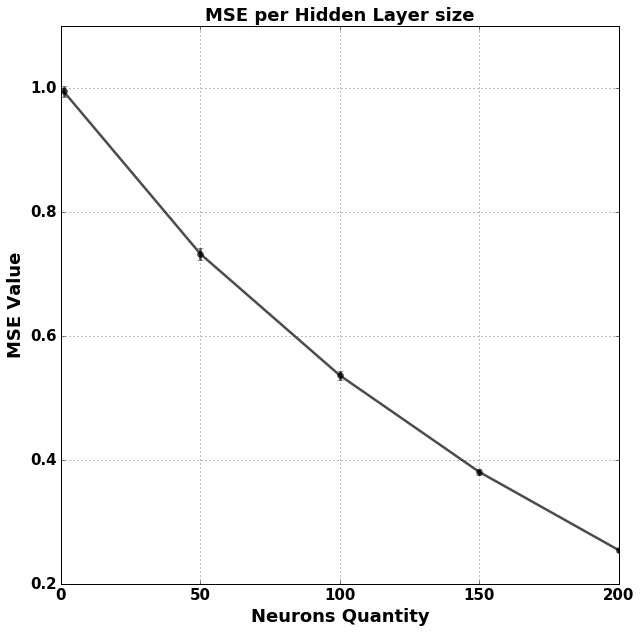

In [70]:
# Neuron variation x MSE

from sklearn import preprocessing
from sklearn import metrics

from keras.utils import np_utils
from keras.models import load_model

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

current_analysis = 'mse'

hidden_neurons = [300,200]
layer = 3

neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
analysis_file_name='%s/%s/%s_%s_third_layer_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name, current_analysis)
    
if os.path.exists(analysis_file_name):
    os.remove(analysis_file_name)

if not os.path.exists(analysis_file_name):
    trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)

    if not os.path.exists(trn_params_folder):
        trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                             hidden_activation='tanh',
                                                             output_activation='linear',
                                                             n_epochs=500,
                                                             patience=30,
                                                             batch_size=256,
                                                             verbose=False)
        trn_params.save(trn_params_folder)
    else:
        trn_params = trnparams.NeuralClassificationTrnParams()
        trn_params.load(trn_params_folder)

    params_str = trn_params.get_params_str()

    neurons_mat = neurons
    
    mse_mat = np.zeros([n_folds,len(neurons_mat)])

    for ifold in range(len(CVO)):
        train_id, test_id = CVO[ifold]

        # normalize data based in train set
        if trn_params.params['norm'] == 'mapstd':
            scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapstd_rob':
            scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapminmax':
            scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

        norm_data = scaler.transform(all_data[test_id,:])
        
        for ineuron,neuron_value in enumerate(neurons_mat):     
            if neuron_value == 0:
                neuron_value = 1

            # First Layer
            previous_model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                                                    prefix_str,
                                                                    n_folds,
                                                                    params_str,
                                                                    hidden_neurons[0])

            if not development_flag:
                file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
            else:
                file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
            # Get the first layer weights
            first_layer_model = load_model(file_name)
            encoder_first_layer = first_layer_model.layers[0].get_weights()
            decoder_first_layer = first_layer_model.layers[2].get_weights()

            # Second Layer
            previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%i_neurons'%(save_path,analysis_str,
                                                                    prefix_str,
                                                                    n_folds,
                                                                    params_str,
                                                                    hidden_neurons[0],
                                                                    hidden_neurons[1])

            if not development_flag:
                file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
            else:
                file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
            # Get the second layer projection of data
            second_layer_model = load_model(file_name)
            encoder_second_layer = second_layer_model.layers[0].get_weights()
            decoder_second_layer = second_layer_model.layers[2].get_weights()

            # Third Layer
            previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%ix%i_neurons'%(save_path,
                                                                              analysis_str,
                                                                              prefix_str,
                                                                              n_folds,
                                                                              params_str,
                                                                              hidden_neurons[0],
                                                                              hidden_neurons[1],
                                                                              neuron_value)

            if not development_flag:
                file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
            else:
                file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
                
            # Get the third layer projection of data
            print '[*] Loading %s'%file_name
            try:
                third_layer_model = load_model(file_name)
            except: 
                print file_name
                break
                
            encoder_third_layer = third_layer_model.layers[0].get_weights()
            decoder_third_layer = third_layer_model.layers[2].get_weights()

            model = Sequential()
            # Encoder
            model.add(Dense(hidden_neurons[0], input_dim=norm_data.shape[1], weights=encoder_first_layer,
                            trainable=False))
            model.add(Activation(trn_params.params['hidden_activation']))

            model.add(Dense(hidden_neurons[1], weights=encoder_second_layer, trainable=False))
            model.add(Activation(trn_params.params['hidden_activation']))

            model.add(Dense(neuron_value, weights=encoder_third_layer, trainable=False))
            model.add(Activation(trn_params.params['hidden_activation']))

            # Decoder
            model.add(Dense(hidden_neurons[1], weights=decoder_third_layer, trainable=False))
            model.add(Activation(trn_params.params['output_activation']))

            model.add(Dense(hidden_neurons[0], weights=decoder_second_layer, trainable=False))
            model.add(Activation(trn_params.params['output_activation']))

            model.add(Dense(norm_data.shape[1], weights=decoder_first_layer, trainable=False))
            model.add(Activation(trn_params.params['output_activation'], trainable=False))
            
            output = model.predict(norm_data)
            mse = metrics.mean_squared_error(norm_data, output)
            mse_mat[ifold,ineuron] = mse
            
    joblib.dump([mse_mat,neurons_mat],analysis_file_name,compress=9)
else:
    [mse_mat,neurons_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig, ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1)

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

ax.errorbar(neurons_mat,np.mean(mse_mat,axis=0),
            np.std(mse_mat,axis=0),fmt='o-',
            color='k',alpha=0.7,linewidth=2.5)

ax.set_title('MSE per Hidden Layer size',fontsize=18,weight='bold')
ax.set_xlabel('Neurons Quantity',fontsize=18,weight='bold')
ax.set_ylabel('MSE Value',fontsize=18,weight='bold') 
ax.grid()
#Save the figure
file_name = pict_results_path+'/'+current_analysis+'_third_layer_'+trn_params.get_params_str()+'.pdf'
plt.savefig(file_name)
print "Topology (%s)"%trn_params.get_params_str()


# Autocorrelação Entrada x Saída - 3ª Camada

[*] Loading topology 400x400x350x300 for fold 0
[*] Loading topology 400x400x350x300 for fold 1
Topology (1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation)


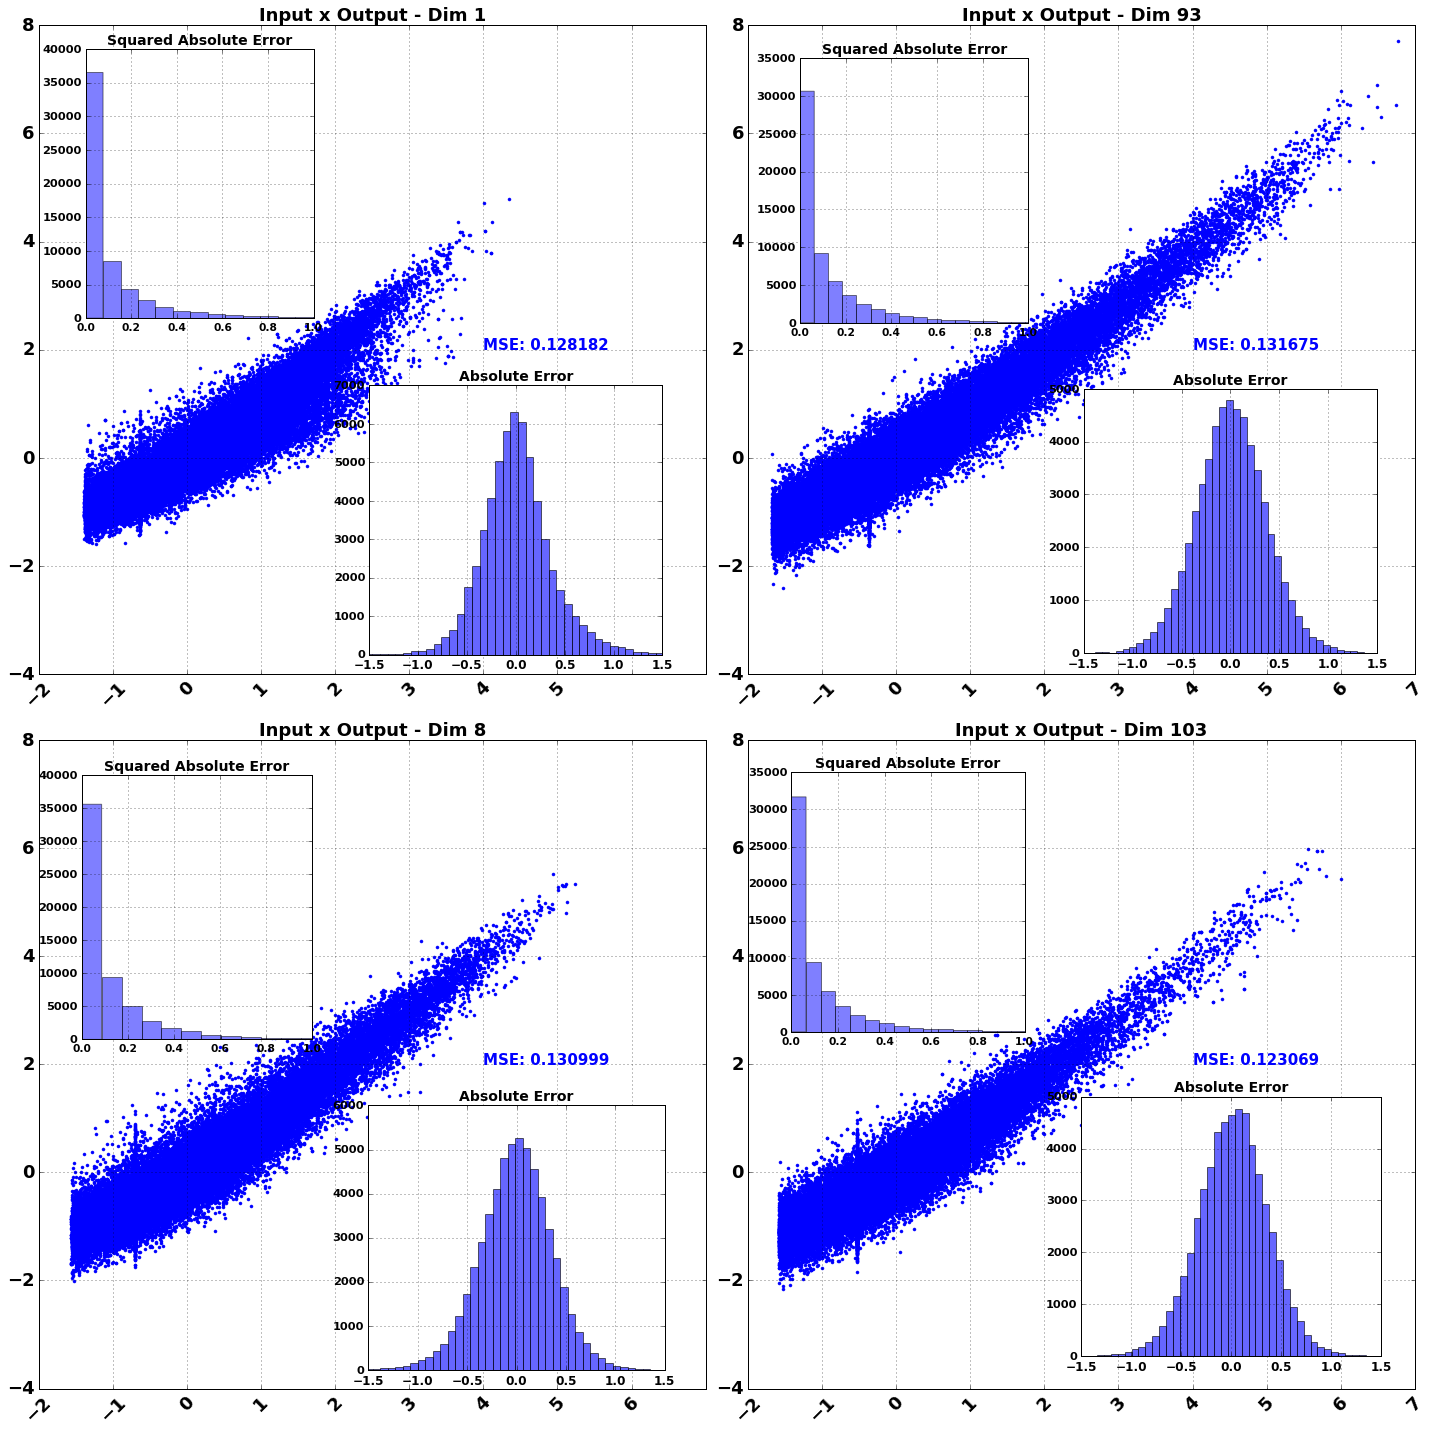

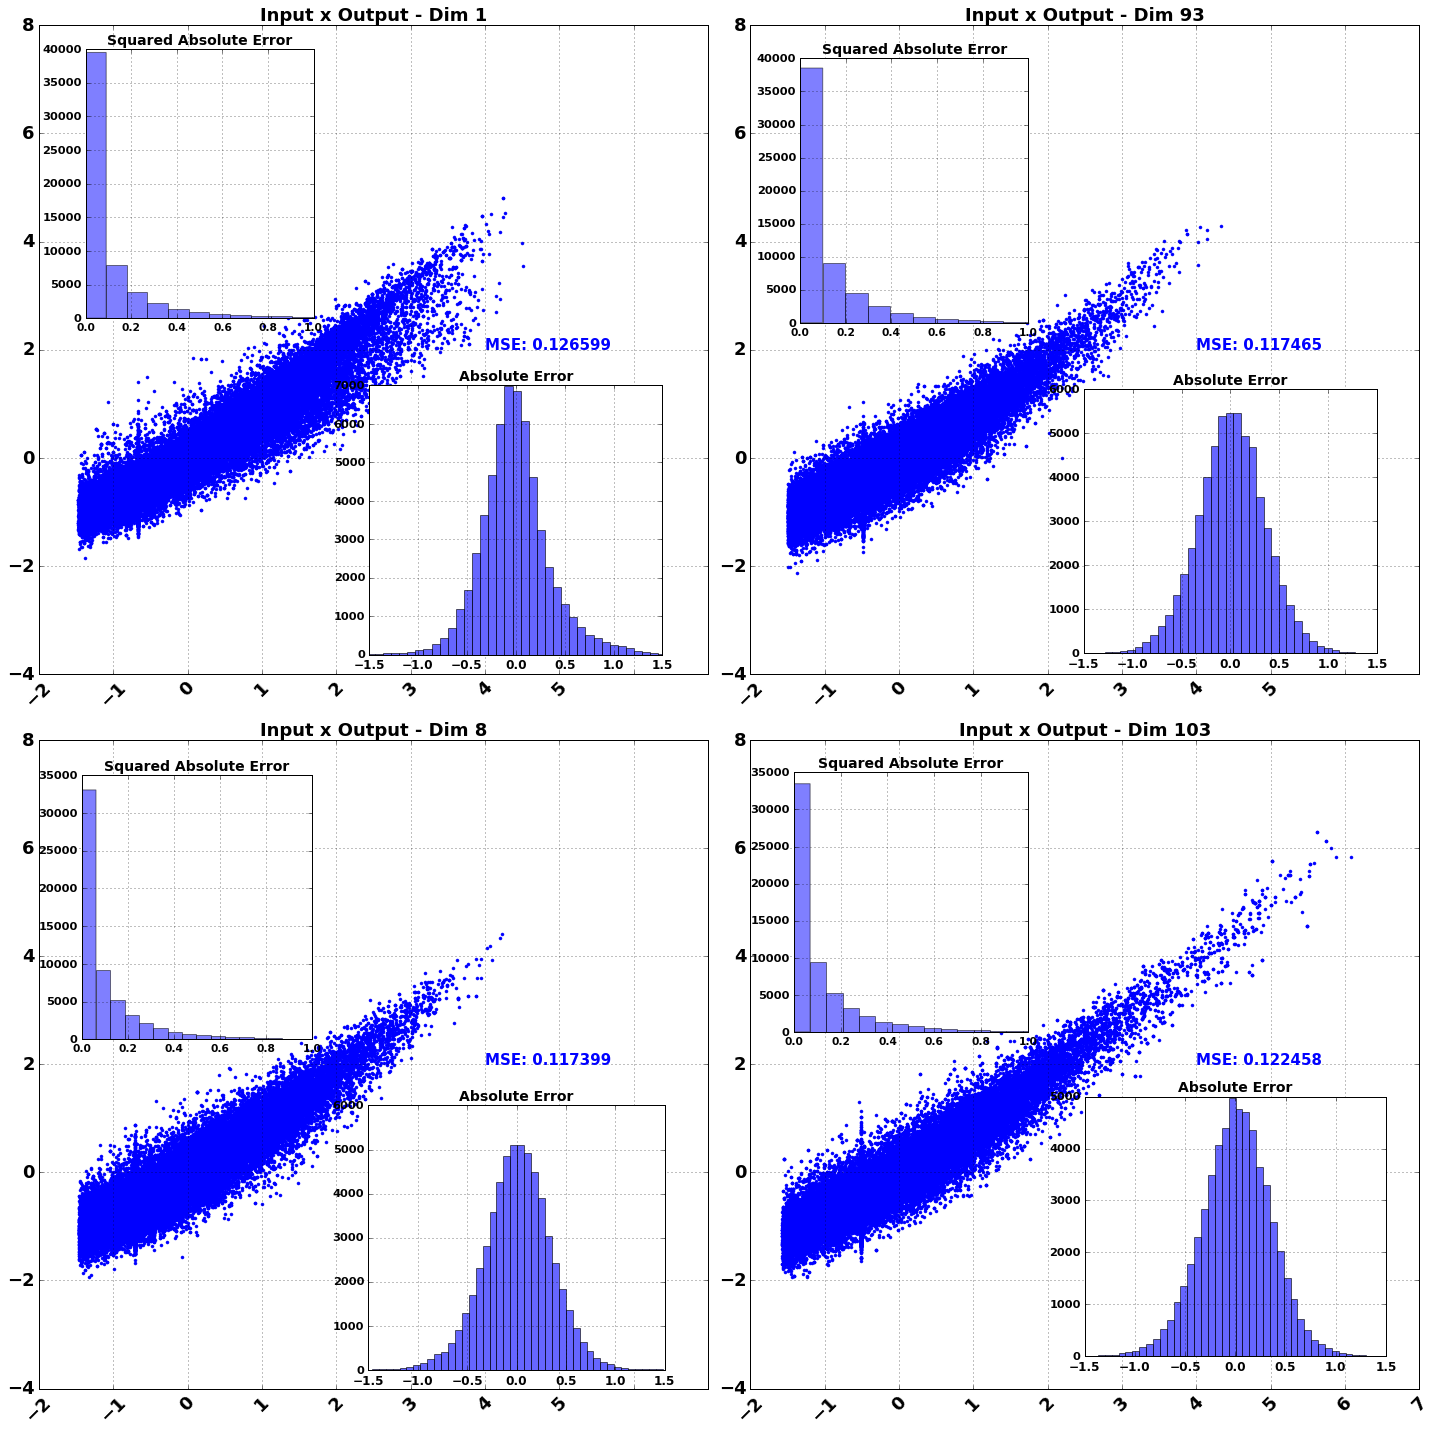

In [33]:
# Analysis of Reconstruction Input x Output

import matplotlib.pyplot as plt
%matplotlib inline  

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'

current_analysis = 'reconstruction_inputxoutput'

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3

# Topology
hidden_neurons = [400, 350, 300]

neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
    
models = {}
outputs = {}
mean = {}
indexes = {}

# Load Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)

if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='relu',
                                                         output_activation='linear',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()

for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data)
    norm_data = norm_data[test_id,:]
    
    if ifold == 0:
        diffSquared = np.zeros([len(CVO),norm_data.shape[0],norm_data.shape[1]])
     
    print '[*] Loading topology %s for fold %i'%(neurons_str, ifold)
    # First Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the first layer weights
    first_layer_model = load_model(file_name)
    encoder_first_layer = first_layer_model.layers[0].get_weights()
    decoder_first_layer = first_layer_model.layers[2].get_weights()
    
    # Second Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the second layer projection of data
    second_layer_model = load_model(file_name)
    encoder_second_layer = second_layer_model.layers[0].get_weights()
    decoder_second_layer = second_layer_model.layers[2].get_weights()
    
    # Third Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1],
                                                            hidden_neurons[2])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the third layer projection of data
    third_layer_model = load_model(file_name)
    encoder_third_layer = third_layer_model.layers[0].get_weights()
    decoder_third_layer = third_layer_model.layers[2].get_weights()
    
    model = Sequential()
    # Encoder
    model.add(Dense(hidden_neurons[0], input_dim=norm_data.shape[1], weights=encoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    model.add(Dense(hidden_neurons[1], weights=encoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    model.add(Dense(hidden_neurons[2], weights=encoder_third_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    # Decoder
    model.add(Dense(hidden_neurons[1], weights=decoder_third_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    
    model.add(Dense(hidden_neurons[0], weights=decoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    
    model.add(Dense(norm_data.shape[1], weights=decoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation'], trainable=False))
    #model.summary()
    all_output = model.predict(norm_data)
    
    outputs[ifold] = all_output
    diffSquared[ifold] = np.power((norm_data - outputs[ifold]), 2) 

mean = np.mean(np.mean(diffSquared, axis=0), axis=0)
indexes = np.argsort(mean)[::-1]

for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data)
    norm_data = norm_data[test_id,:]
    
    points = norm_data.shape[0]
    # Number of dimensions to analyse (even number is better!)
    num_dim = 4
    fig, m_ax = plt.subplots(figsize=(20,20),nrows=2, ncols=2)
    for choose_index in range(num_dim):
        ax = plt.subplot(2,2,choose_index+1)
        ax.plot(norm_data[:,indexes[choose_index]][:points], outputs[ifold][:,indexes[choose_index]][:points],"b.")
        plt.tight_layout()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title('Input x Output - Dim %i'%(indexes[choose_index]),fontsize=18, fontweight='bold')  
        ax.set_xlim(-2, 7)
        ax.set_ylim(-4, 8)
        handles, labels = ax.get_legend_handles_labels()
        plt.legend()
        plt.grid()    
        
        # Small plot
        rect = [0.065, 0.55, 0.35, 0.4]
        ax1 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
        
        eq_reconstruction = np.power((norm_data[:,indexes[choose_index]] - outputs[ifold][:,indexes[choose_index]]), 2)

        mq_bins = np.linspace(np.min(eq_reconstruction), np.max(eq_reconstruction), 50)
  
        n, bins, patches = ax1.hist(eq_reconstruction,bins=mq_bins,
                                    fc="b",
                                    alpha=0.5, normed=0)
        ax1.set_title("Squared Absolute Error",fontsize=14, fontweight='bold')
        ax1.set_xlim(0,1) 
        ax1.grid() 
        
        # Small plot
        rect = [0.5, 0.05, 0.45, 0.4]
        ax2 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
        
        e_reconstruction = (norm_data[:,indexes[choose_index]] - outputs[ifold][:,indexes[choose_index]])

        m_bins = np.linspace(np.min(e_reconstruction), np.max(e_reconstruction), 50)
     
        n, bins, patches = ax2.hist(e_reconstruction,bins=m_bins,
                                    fc="b",
                                    alpha=0.6, normed=0)
        ax2.grid()
        ax2.set_title("Absolute Error",fontsize=14, fontweight='bold')
        ax2.set_xlim(-1.5,1.5) 
        
        plt.legend()
        
        mse = metrics.mean_squared_error(norm_data[:,indexes[choose_index]], outputs[ifold][:,indexes[choose_index]])
        ax.text(4, 2, 'MSE: %f'%mse, style='normal',fontsize=15, color='blue',
        bbox={'alpha':0.0, 'pad':10})
         
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_third_layer_%s_neurons_%i_fold_'%(neurons_str,ifold)+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)
print "Topology (%s)"%trn_params.get_params_str()

# Análise LOFAR para reconstrução da 3ª Camada

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

# LOFARGram for reconstructed input
current_analysis = 'LOFARGram_reconstruction_third_layer'

# Choose num of neurons
hidden_neurons = [400, 350, 300]

# Create a string like InputDimension x FirstLayerDimension x ... x OutputDimension
neurons_str = '400'
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
neurons_str = neurons_str + 'x' + str(all_data.shape[1])

for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data) 
    
    # First Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the first layer weights
    first_layer_model = load_model(file_name)
    encoder_first_layer = first_layer_model.layers[0].get_weights()
    decoder_first_layer = first_layer_model.layers[2].get_weights()
    #first_layer_model.summary()
    
    # Second Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the second layer projection of data
    second_layer_model = load_model(file_name)
    encoder_second_layer = second_layer_model.layers[0].get_weights()
    decoder_second_layer = second_layer_model.layers[2].get_weights()
    #second_layer_model.summary()
    
    # Third Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1],
                                                            hidden_neurons[2])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the third layer projection of data
    third_layer_model = load_model(file_name)
    encoder_third_layer = third_layer_model.layers[0].get_weights()
    decoder_third_layer = third_layer_model.layers[2].get_weights()
    #third_layer_model.summary()
    
    model = Sequential()
    # Encoder
    model.add(Dense(hidden_neurons[0], input_dim=norm_data.shape[1], weights=encoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    model.add(Dense(hidden_neurons[1], weights=encoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    model.add(Dense(hidden_neurons[2], weights=encoder_third_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    # Decoder
    model.add(Dense(hidden_neurons[1], weights=decoder_third_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    
    model.add(Dense(hidden_neurons[0], weights=decoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    
    model.add(Dense(norm_data.shape[1], weights=decoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation'], trainable=False))
    #model.summary()
    all_output = model.predict(norm_data)
    
    m_fontsize = 15

    fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,10))
    for iclass, class_label in enumerate(class_labels):
        ax = plt.subplot(2,2,iclass+1)
        plt.title('Lofar Analysis for Class %s'%(class_label), fontsize= m_fontsize, fontweight="bold")

        if iclass > 1:
            plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
        if ((iclass == 0) or (iclass==2)):
            plt.ylabel('Time (seconds)', fontsize= m_fontsize, fontweight="bold")

        plt.imshow(all_output[all_trgt==iclass,:],
               cmap="jet",extent=[1, 400, all_output[all_trgt==iclass,:].shape[0],1],
               aspect="auto")
        plt.xticks(np.linspace(0,400,9),rotation=45)
        cbar = plt.colorbar()
        plt.clim(-2,9)
        #if ((iclass == 1) or (iclass==3)):
        cbar.ax.set_ylabel('dB',fontweight='bold') 
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_%s'%neurons_str+'_%i'%ifold+'_fold'+'_'+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)

In [ ]:
# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

# LOFARGram for reconstructed input with lines
current_analysis = 'LOFARGram_reconstruction_x_original_third_layer'

# Choose num of neurons
hidden_neurons = [400, 350, 300]

neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)

# Choose class
iclass = 1

for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data)    
    
    # First Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the first layer weights
    first_layer_model = load_model(file_name)
    encoder_first_layer = first_layer_model.layers[0].get_weights()
    decoder_first_layer = first_layer_model.layers[2].get_weights()
    
    # Second Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the second layer projection of data
    second_layer_model = load_model(file_name)
    encoder_second_layer = second_layer_model.layers[0].get_weights()
    decoder_second_layer = second_layer_model.layers[2].get_weights()
    
    
    # Third Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1],
                                                            hidden_neurons[2])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the third layer projection of data
    third_layer_model = load_model(file_name)
    encoder_third_layer = third_layer_model.layers[0].get_weights()
    decoder_third_layer = third_layer_model.layers[2].get_weights()
    
    model = Sequential()
    # Encoder
    model.add(Dense(hidden_neurons[0], input_dim=norm_data.shape[1], weights=encoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    model.add(Dense(hidden_neurons[1], weights=encoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    model.add(Dense(hidden_neurons[2], weights=encoder_third_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    # Decoder
    model.add(Dense(hidden_neurons[1], weights=decoder_third_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    
    model.add(Dense(hidden_neurons[0], weights=decoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    
    model.add(Dense(norm_data.shape[1], weights=decoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation'], trainable=False))
    #model.summary()
    all_output = model.predict(norm_data)

    m_fontsize = 12

    fig, subplot_array = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
    for i in range(2):
        ax = plt.subplot(1,2,i+1)
        if i == 0:
            plt.imshow(norm_data[all_trgt==iclass,:],
               cmap="jet",extent=[1, 400, norm_data[all_trgt==iclass,:].shape[0],1],
               aspect="auto")
            plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
            plt.title('Lofar Analysis for Original Data of %s'%(class_labels[iclass]), fontsize= m_fontsize, fontweight="bold")
        if (i == 1):
            plt.ylabel('Time (seconds)', fontsize= m_fontsize, fontweight="bold")
            plt.imshow(all_output[all_trgt==iclass,:],
               cmap="jet",extent=[1, 400, all_output[all_trgt==iclass,:].shape[0],1],
               aspect="auto")
            plt.title('Lofar Analysis for Reconstructed Data of %s'%(class_labels[iclass]), fontsize= m_fontsize, fontweight="bold")
       
        plt.xticks(np.linspace(0,400,9),rotation=45)
        cbar = plt.colorbar()
        plt.clim(-2,9)
        #if ((iclass == 1) or (iclass==3)):
        cbar.ax.set_ylabel('dB',fontweight='bold') 
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_%i'%ifold+'_fold'+'_%s'%neurons_str+'_neurons_%i_class_'%(1+iclass)+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)

# Treinamento de Classificação - 3ª Camada

In [ ]:
%time
# Load Parameters
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
#os.remove(trn_params_folder)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear', # For AutoEncoder
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

In [71]:
%time
from Functions import TrainFunctions
def SAEClassificationtrainFold(ifold):
    return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                          trgt=all_trgt,
                                          ifold=ifold,
                                          n_folds=n_folds, 
                                          hidden_neurons=(300,200,100),
                                          trn_params=trn_params, 
                                          save_path=results_path,
                                          dev=development_flag)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs


In [72]:
%time

p = multiprocessing.Pool(processes=num_processes)
start_time = time.time()

folds = range(len(CVO))
# To train on multiple cores sweeping the number of folds
results = p.map(SAEClassificationtrainFold, folds)

# To train on multiple cores sweeping the number of neurons
#results = p.map(trainNeuron, neurons)

p.close()
p.join()

end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs
Fold 1 of 2 Folds -  Init 1 of 1 Inits
Fold 2 of 2 Folds -  Init 1 of 1 Inits
It took 3777.322 seconds to perform the training


# Análise de Classificação - 3ª Camada

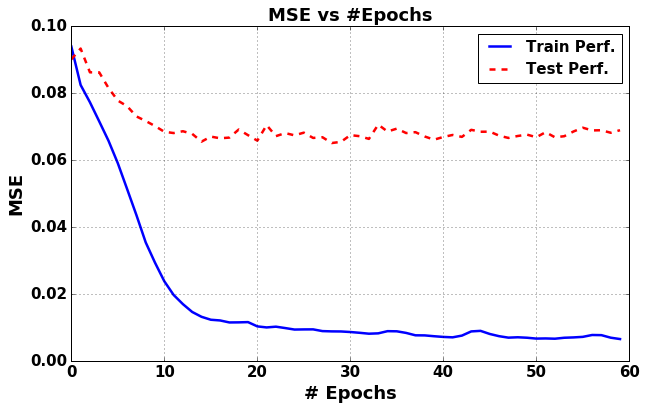

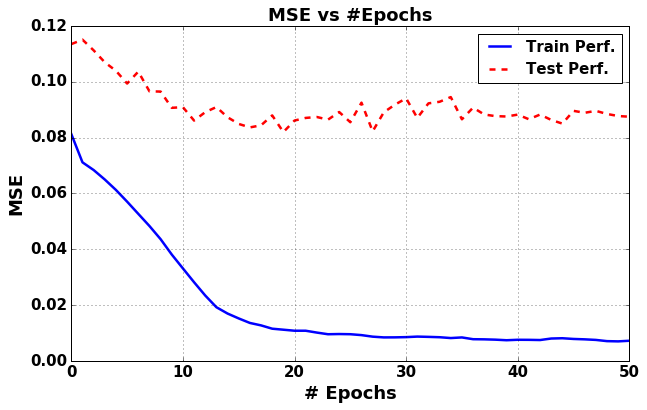

In [15]:
# Mean Squared Error x Epochs
%matplotlib inline  
import matplotlib.pyplot as plt

current_analysis = 'mse'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

hidden_neurons = [400,300,200]

# Parameters
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()

# plot train updates
for ifold in range(len(CVO)):
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    plt.rc('legend',**{'fontsize':15})
    plt.rc('font', weight='bold')
    
    fig1 = plt.figure(figsize=(10,6))
    
    neurons_str = '400'
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    model_str = '%s/%s/Classification_(%s)_%s_%i_folds_%s'%(save_path,analysis_str,
                                                            neurons_str,
                                                            prefix_str, n_folds,
                                                            params_str)

    if not development_flag:        
        load_file_name = '%s_fold_%i_trn_desc.jbl'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_trn_desc_dev.jbl'%(model_str,ifold)
        print load_file_name
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    [trn_desc] = joblib.load(load_file_name)

    l1 = plt.plot(trn_desc['epochs'],
                  trn_desc['loss'],color=[0,0,1],
                  linewidth=2.5,linestyle='solid',label='Train Perf.')
    l2 = plt.plot(trn_desc['epochs'],
                  trn_desc['val_loss'],color=[1,0,0],
                  linewidth=2.5,linestyle='dashed',label='Test Perf.')
    cost = ''
    cost = 'MSE'

    plt.grid(True)
    plt.xlabel("# Epochs",fontsize=18,fontweight='bold')
    plt.ylabel(cost,fontsize=18,fontweight='bold')
    plt.title(cost+" vs #Epochs",fontsize=18,fontweight='bold')
    plt.legend()
    #Save the figure
    file_name = pict_results_path+'/Classification_(%s)_'%neurons_str\
        +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)

Topology (Classification_(400x300x200x100x4)_RawData_2_folds_1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation)


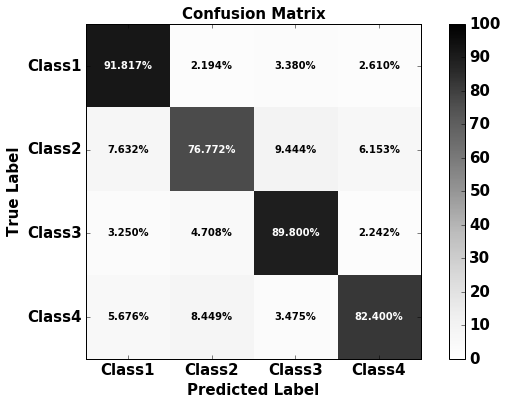

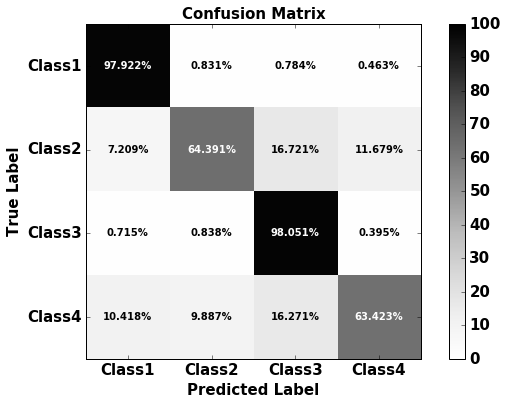

In [73]:
# Confusion Matrix

%matplotlib inline  
from sklearn import preprocessing
import matplotlib.pyplot as plt

current_analysis = 'confusion_matrix'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path


hidden_neurons = [300, 200, 100]
analysis_full_data = False

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear', # for autoencoders
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.set_aspect(1)

    from sklearn.metrics import confusion_matrix

    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
    
    if analysis_full_data:
        norm_data = scaler.transform(all_data)
        norm_trgt = all_trgt
    else: 
        norm_data = scaler.transform(all_data[test_id, :])
        norm_trgt = all_trgt[test_id]
    
    neurons_str = str(all_data.shape[1])
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
    
    all_output = np.argmax(output,axis=1)
    cm = confusion_matrix(norm_trgt, all_output)
    cm_normalized = 100.*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im =ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

    width, height = cm_normalized.shape

    for x in xrange(width):
        for y in xrange(height):
            if cm_normalized[x][y] < 50.:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center')
            else:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center',color='white')

    ax.set_title('Confusion Matrix',fontweight='bold',fontsize=15)
    fig.colorbar(im)
    tick_marks = np.arange(len(labels))
    ax.xaxis.set_ticks(tick_marks)
    ax.xaxis.set_ticklabels(labels)

    ax.yaxis.set_ticks(tick_marks)
    ax.yaxis.set_ticklabels(labels)

    ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
    ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
    
    #Save the figure
    if analysis_full_data:
        file_name = pict_results_path+'/Classification_(%s)_all_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    else: 
        file_name = pict_results_path+'/Classification_(%s)_test_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print 'Topology (%s)'%topology
if analysis_full_data:
    print 'Analysis in All Data'

In [ ]:
# Histogram

%matplotlib inline  
from sklearn import preprocessing

current_analysis = 'histogram'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

# Choose Topology
hidden_neurons = [400,300,200]
analysis_full_data = False

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    if analysis_full_data:
        norm_data = scaler.transform(all_data)
        norm_trgt = all_trgt
    else: 
        norm_data = scaler.transform(all_data[test_id, :])
        norm_trgt = all_trgt[test_id]
    
    neurons_str = str(all_data.shape[1])
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
    # Check if the topology has already been trained    
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   
    from sklearn.neighbors import KernelDensity

    m_bins = np.linspace(-0.5, 1.5, 50)

    m_colors = ['b', 'r', 'g', 'y']
    
    for i_target in range(trgt_sparse[test_id].shape[1]):
        for i_output in range(output.shape[1]):
            subplot_id = output.shape[1]*i_target+i_output
            m_pts = output[norm_trgt==i_target,i_output]

            n, bins, patches = ax[i_target,i_output].hist(m_pts,bins=m_bins,
                                                          fc=m_colors[i_target],
                                                          alpha=0.8, normed=0)

            if i_output == 0:
                ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                                 fontweight='bold',fontsize=15)
            if i_target == 3:
                ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                                 fontweight='bold',fontsize=15)
            ax[i_target,i_output].grid()
    
    #Save the figure
    if analysis_full_data:
        file_name = pict_results_path+'/Classification_(%s)_all_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    else: 
        file_name = pict_results_path+'/Classification_(%s)_test_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print 'Topology (%s)'%topology
if analysis_full_data:
    print 'Analysis in All Data'

In [ ]:
# Kernel Density

%matplotlib inline  
from sklearn import preprocessing
import matplotlib.pyplot as plt

current_analysis = 'kernel_density'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

# Choose Topology
hidden_neurons = [400,300,200]
analysis_full_data = False

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    if analysis_full_data:
        norm_data = scaler.transform(all_data)
        norm_trgt = all_trgt
    else: 
        norm_data = scaler.transform(all_data[test_id, :])
        norm_trgt = all_trgt[test_id]
    
    neurons_str = str(all_data.shape[1])
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name 
    # Check if the topology has already been trained    
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   
    from sklearn.neighbors import KernelDensity

    m_bins = np.linspace(-0.5, 1.5,100)

    m_colors = ['b', 'r', 'g', 'y']

    kernel = 'gaussian' # other kernels: 'gaussian', 'tophat', 
                        #'epanechnikov', 'exponential', 'linear', 'cosine'
    for i_target in range(trgt_sparse[test_id].shape[1]):
        for i_output in range(output.shape[1]):
            subplot_id = output.shape[1]*i_target+i_output
            m_pts = output[norm_trgt==i_target,i_output]

            kde = KernelDensity(kernel=kernel,algorithm='auto',
                                bandwidth=0.5).fit(m_pts[:, np.newaxis])
            log_dens_x = kde.score_samples(m_bins[:, np.newaxis])
            ax[i_target,i_output].plot(m_bins, np.exp(log_dens_x),
                                       color=m_colors[i_target],linewidth=2.0)
            if i_output == 0:
                ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                                 fontweight='bold',fontsize=15)
            if i_target == 3:
                ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                                 fontweight='bold',fontsize=15)
            ax[i_target,i_output].grid()
    
    #Save the figure
    if analysis_full_data:
        file_name = pict_results_path+'/Classification_(%s)_all_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    else: 
        file_name = pict_results_path+'/Classification_(%s)_test_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print 'Topology (%s)'%topology
if analysis_full_data:
    print 'Analysis in All Data'

In [ ]:
# Classification Report

current_analysis = 'report'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

# Choose Topology
hidden_neurons = [400,300,200]
analysis_full_data = False

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)
params_str = trn_params.get_params_str()

neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])

print "Results for (%s) neurons (%s)"%(neurons_str, params_str)
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data[test_id,:])
    
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name
    # Check if the topology has already been trained    
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   
    num_classes = len(class_labels.keys())
    
    efficiency = metrics.recall_score(trgt_sparse[test_id], np.round(output), average=None)
    sp_index = np.sum(efficiency)/num_classes * np.power(np.prod(efficiency), 1/num_classes)
    sp_index = np.sqrt(sp_index)
    
    precision = metrics.precision_score(trgt_sparse[test_id], np.round(output), average=None)
    f1_score = metrics.f1_score(trgt_sparse[test_id], np.round(output), average=None)
    print '\tPrecision\tEfficiency\tF1_Score'
    for iclass in range(num_classes):
        print '%s:\t%f\t%f\t%f\n'%(class_labels[iclass], precision[iclass], efficiency[iclass],f1_score[iclass])
    print 'SP index: %f\n'%sp_index
   

# Treinamento da 4ª Camada

In [23]:
%%time

hidden_neurons = [400, 350, 300]

# To train on multiple cores sweeping the number of folds
def trainFold(ifold):
    ineuron = 100
    return TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                                trgt=all_data,
                                ifold=ifold,
                                n_folds=n_folds, 
                                n_neurons=ineuron,
                                trn_params=trn_params, 
                                save_path=results_path,
                                dev=development_flag,
                                layer = 4,
                                hidden_neurons = hidden_neurons)
    
# To train on multiple cores sweeping the number of neurons
def trainNeuron(ineuron):
    for ifold in range(len(CVO)):
        TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                            trgt=all_data,
                            ifold=ifold,
                            n_folds=n_folds, 
                            n_neurons=ineuron,
                            trn_params=trn_params, 
                            save_path=results_path,
                            dev=development_flag,
                            layer = 4,
                            hidden_neurons = hidden_neurons)
print trn_params.get_params_str()

1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation
CPU times: user 365 µs, sys: 5 µs, total: 370 µs
Wall time: 276 µs


In [24]:
%time
p = multiprocessing.Pool(processes=num_processes)
start_time = time.time()

folds = range(len(CVO))
neurons = [1, 50, 100, 200, 250, 300]# Train from 0 to 300

# To train on multiple cores sweeping the number of folds
#results = p.map(trainFold, folds)

# To train on multiple cores sweeping the number of neurons
results = p.map(trainNeuron, neurons)

p.close()
p.join()
end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.01 µs
It took 0.110 seconds to perform the training


# Análise da variação do número de neurônios - 4ª Camada

[*] Loading /home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/StackedAutoEncoder/RawData_2_folds_1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation_400x400x350x300x1_neurons_fold_0_model.h5
[*] Loading /home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/StackedAutoEncoder/RawData_2_folds_1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation_400x400x350x300x50_neurons_fold_0_model.h5
[*] Loading /home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/StackedAutoEncoder/RawData_2_folds_1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation_400x400x350x300x100_neurons_fold_0_model.h5
[*] Loading /home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/StackedAutoEncoder/RawData_2_folds_1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation_400x400x350x300x200_neurons_fold_0_

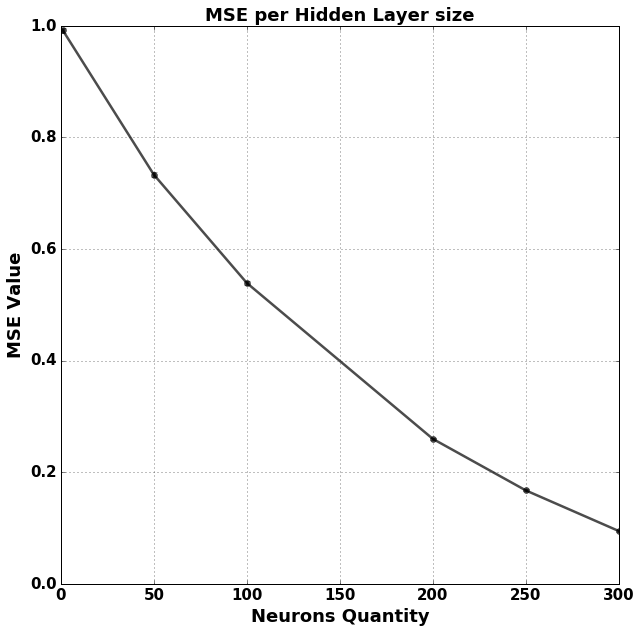

In [25]:
# Neuron variation x MSE

from sklearn import preprocessing
from sklearn import metrics

from keras.utils import np_utils
from keras.models import load_model

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'

current_analysis = 'mse'

hidden_neurons = [400,350,300]
neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
analysis_file_name='%s/%s/%s_%s_fourth_layer_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name, current_analysis)

if os.path.exists(analysis_file_name):
    os.remove(analysis_file_name)

if not os.path.exists(analysis_file_name):
    trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)

    if not os.path.exists(trn_params_folder):
        trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                             hidden_activation='tanh',
                                                             output_activation='linear',
                                                             n_epochs=500,
                                                             patience=30,
                                                             batch_size=256,
                                                             verbose=False)
        trn_params.save(trn_params_folder)
    else:
        trn_params = trnparams.NeuralClassificationTrnParams()
        trn_params.load(trn_params_folder)

    params_str = trn_params.get_params_str()
  
    neurons_mat = neurons
    neurons_mat.sort()
    
    mse_mat = np.zeros([n_folds,len(neurons_mat)])

    for ifold in range(len(CVO)):
        train_id, test_id = CVO[ifold]

        # normalize data based in train set
        if trn_params.params['norm'] == 'mapstd':
            scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapstd_rob':
            scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapminmax':
            scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

        norm_data = scaler.transform(all_data)
        
        for ineuron,neuron_value in enumerate(neurons_mat):     
            if neuron_value == 0:
                neuron_value = 1

            # First Layer
            previous_model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                                                    prefix_str,
                                                                    n_folds,
                                                                    params_str,
                                                                    hidden_neurons[0])

            if not development_flag:
                file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
            else:
                file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
            # Get the first layer weights
            first_layer_model = load_model(file_name)
            encoder_first_layer = first_layer_model.layers[0].get_weights()
            decoder_first_layer = first_layer_model.layers[2].get_weights()

            # Second Layer
            previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%i_neurons'%(save_path,analysis_str,
                                                                    prefix_str,
                                                                    n_folds,
                                                                    params_str,
                                                                    hidden_neurons[0],
                                                                    hidden_neurons[1])

            if not development_flag:
                file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
            else:
                file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
            # Get the second layer projection of data
            second_layer_model = load_model(file_name)
            encoder_second_layer = second_layer_model.layers[0].get_weights()
            decoder_second_layer = second_layer_model.layers[2].get_weights()

            # Third Layer
            previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%ix%i_neurons'%(save_path,
                                                                              analysis_str,
                                                                              prefix_str,
                                                                              n_folds,
                                                                              params_str,
                                                                              hidden_neurons[0],
                                                                              hidden_neurons[1],
                                                                              hidden_neurons[2])

            if not development_flag:
                file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
            else:
                file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
            # Get the third layer projection of data
            third_layer_model = load_model(file_name)
                
            encoder_third_layer = third_layer_model.layers[0].get_weights()
            decoder_third_layer = third_layer_model.layers[2].get_weights()

            # Fourth Layer
            previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%ix%ix%i_neurons'%(save_path,
                                                                              analysis_str,
                                                                              prefix_str,
                                                                              n_folds,
                                                                              params_str,
                                                                              hidden_neurons[0],
                                                                              hidden_neurons[1],
                                                                              hidden_neurons[2],
                                                                              neuron_value)

            if not development_flag:
                file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
            else:
                file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
            # Get the third layer projection of data
            fourth_layer_model = load_model(file_name)
            
            encoder_fourth_layer = fourth_layer_model.layers[0].get_weights()
            decoder_fourth_layer = fourth_layer_model.layers[2].get_weights()

            print '[*] Loading %s'%file_name
            
            model = Sequential()
            # Encoder
            model.add(Dense(hidden_neurons[0], input_dim=norm_data.shape[1], weights=encoder_first_layer,
                            trainable=False))
            model.add(Activation(trn_params.params['hidden_activation']))

            model.add(Dense(hidden_neurons[1], weights=encoder_second_layer, trainable=False))
            model.add(Activation(trn_params.params['hidden_activation']))

            model.add(Dense(hidden_neurons[2], weights=encoder_third_layer, trainable=False))
            model.add(Activation(trn_params.params['hidden_activation']))

            model.add(Dense(neuron_value, weights=encoder_fourth_layer, trainable=False))
            model.add(Activation(trn_params.params['hidden_activation']))

            # Decoder
            model.add(Dense(hidden_neurons[2], weights=decoder_fourth_layer, trainable=False))
            model.add(Activation(trn_params.params['output_activation']))

            model.add(Dense(hidden_neurons[1], weights=decoder_third_layer, trainable=False))
            model.add(Activation(trn_params.params['output_activation']))

            model.add(Dense(hidden_neurons[0], weights=decoder_second_layer, trainable=False))
            model.add(Activation(trn_params.params['output_activation']))

            model.add(Dense(norm_data.shape[1], weights=decoder_first_layer, trainable=False))
            model.add(Activation(trn_params.params['output_activation'], trainable=False))
            
            output = model.predict(norm_data)
            mse = metrics.mean_squared_error(norm_data, output)
            mse_mat[ifold,ineuron] = mse
            
    joblib.dump([mse_mat,neurons_mat],analysis_file_name,compress=9)
else:
    [mse_mat,neurons_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig, ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1)

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

ax.errorbar(neurons_mat,np.mean(mse_mat,axis=0),
            np.std(mse_mat,axis=0),fmt='o-',
            color='k',alpha=0.7,linewidth=2.5)

ax.set_title('MSE per Hidden Layer size',fontsize=18,weight='bold')
ax.set_xlabel('Neurons Quantity',fontsize=18,weight='bold')
ax.set_ylabel('MSE Value',fontsize=18,weight='bold') 
ax.grid()
#Save the figure
file_name = pict_results_path+'/'+current_analysis+'_fourth_layer_'+trn_params.get_params_str()+'.pdf'
plt.savefig(file_name)
print "Topology (%s)"%trn_params.get_params_str()


# Autocorrelação Entrada X Saída - 4ª Camada

[*] Loading topology 400x400x350x300x250 for fold 0
[*] Loading topology 400x400x350x300x250 for fold 1
Topology (1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation)


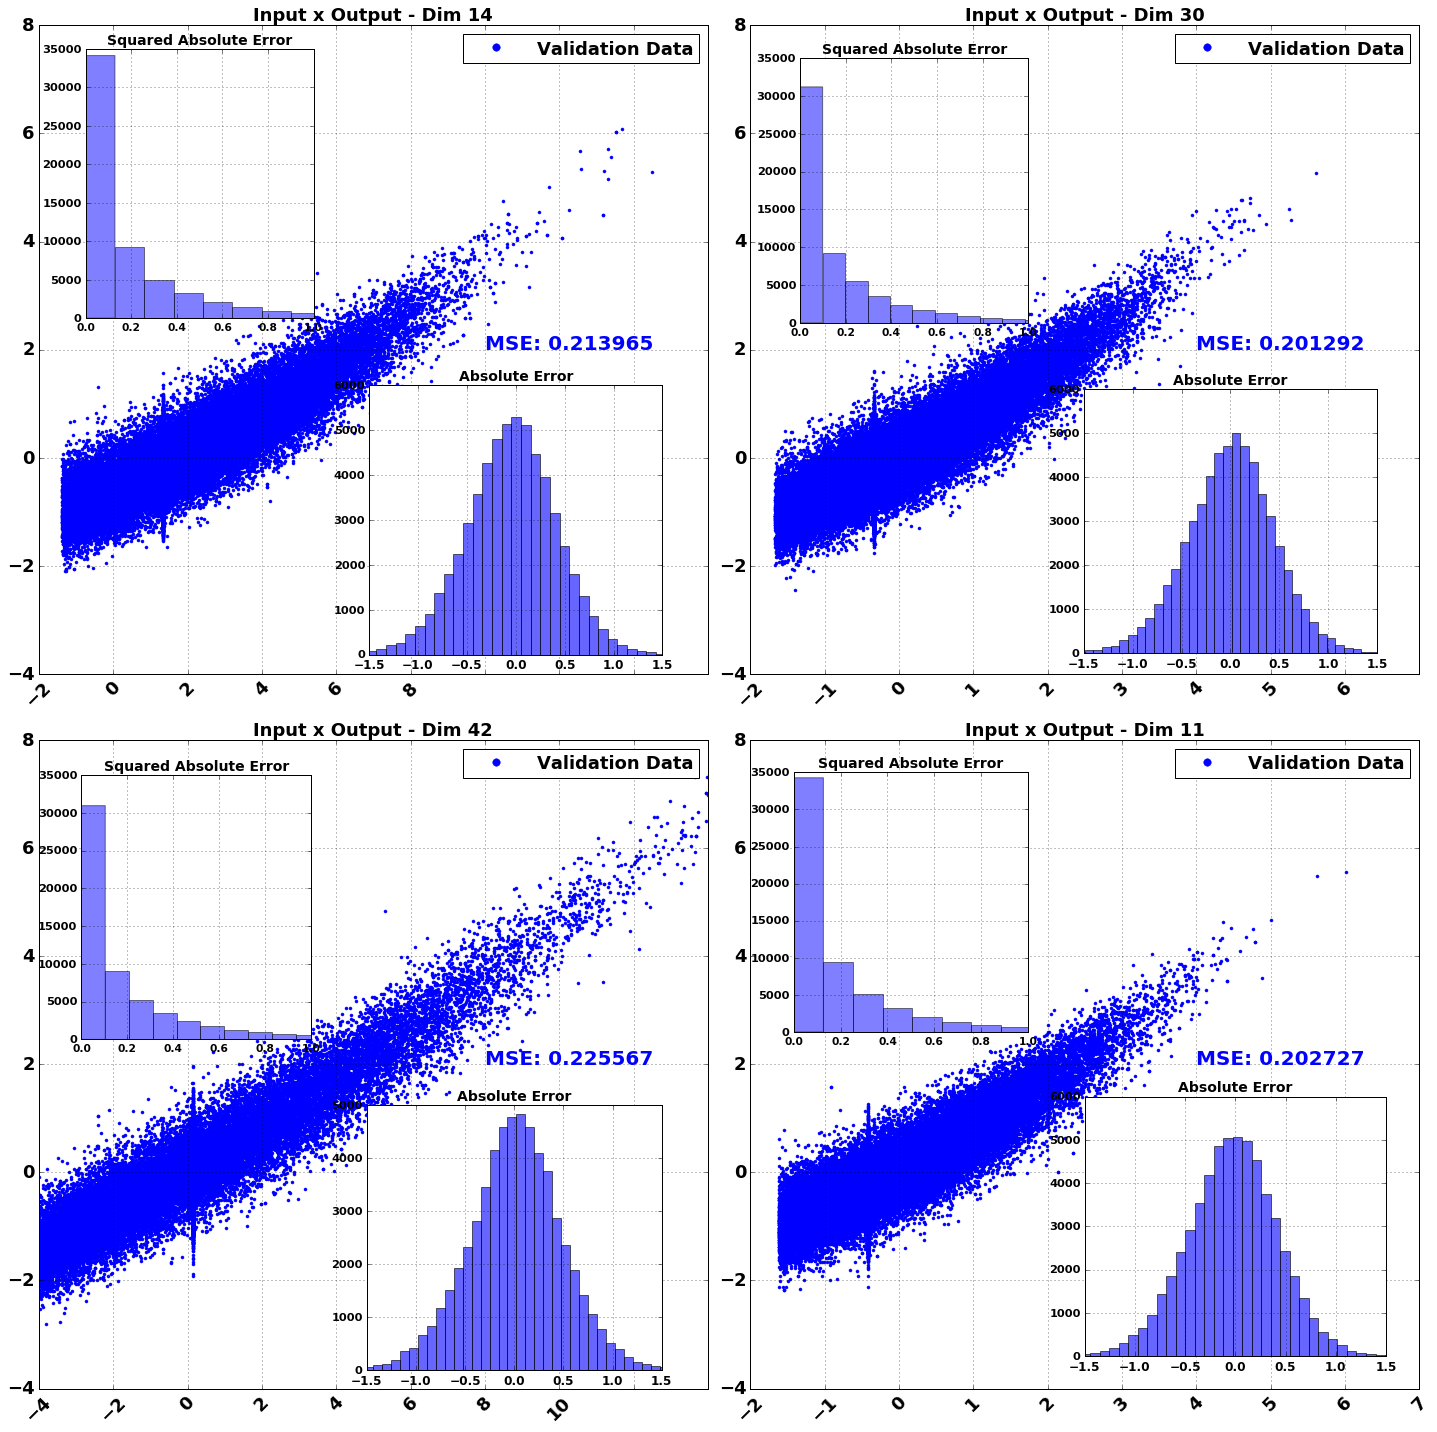

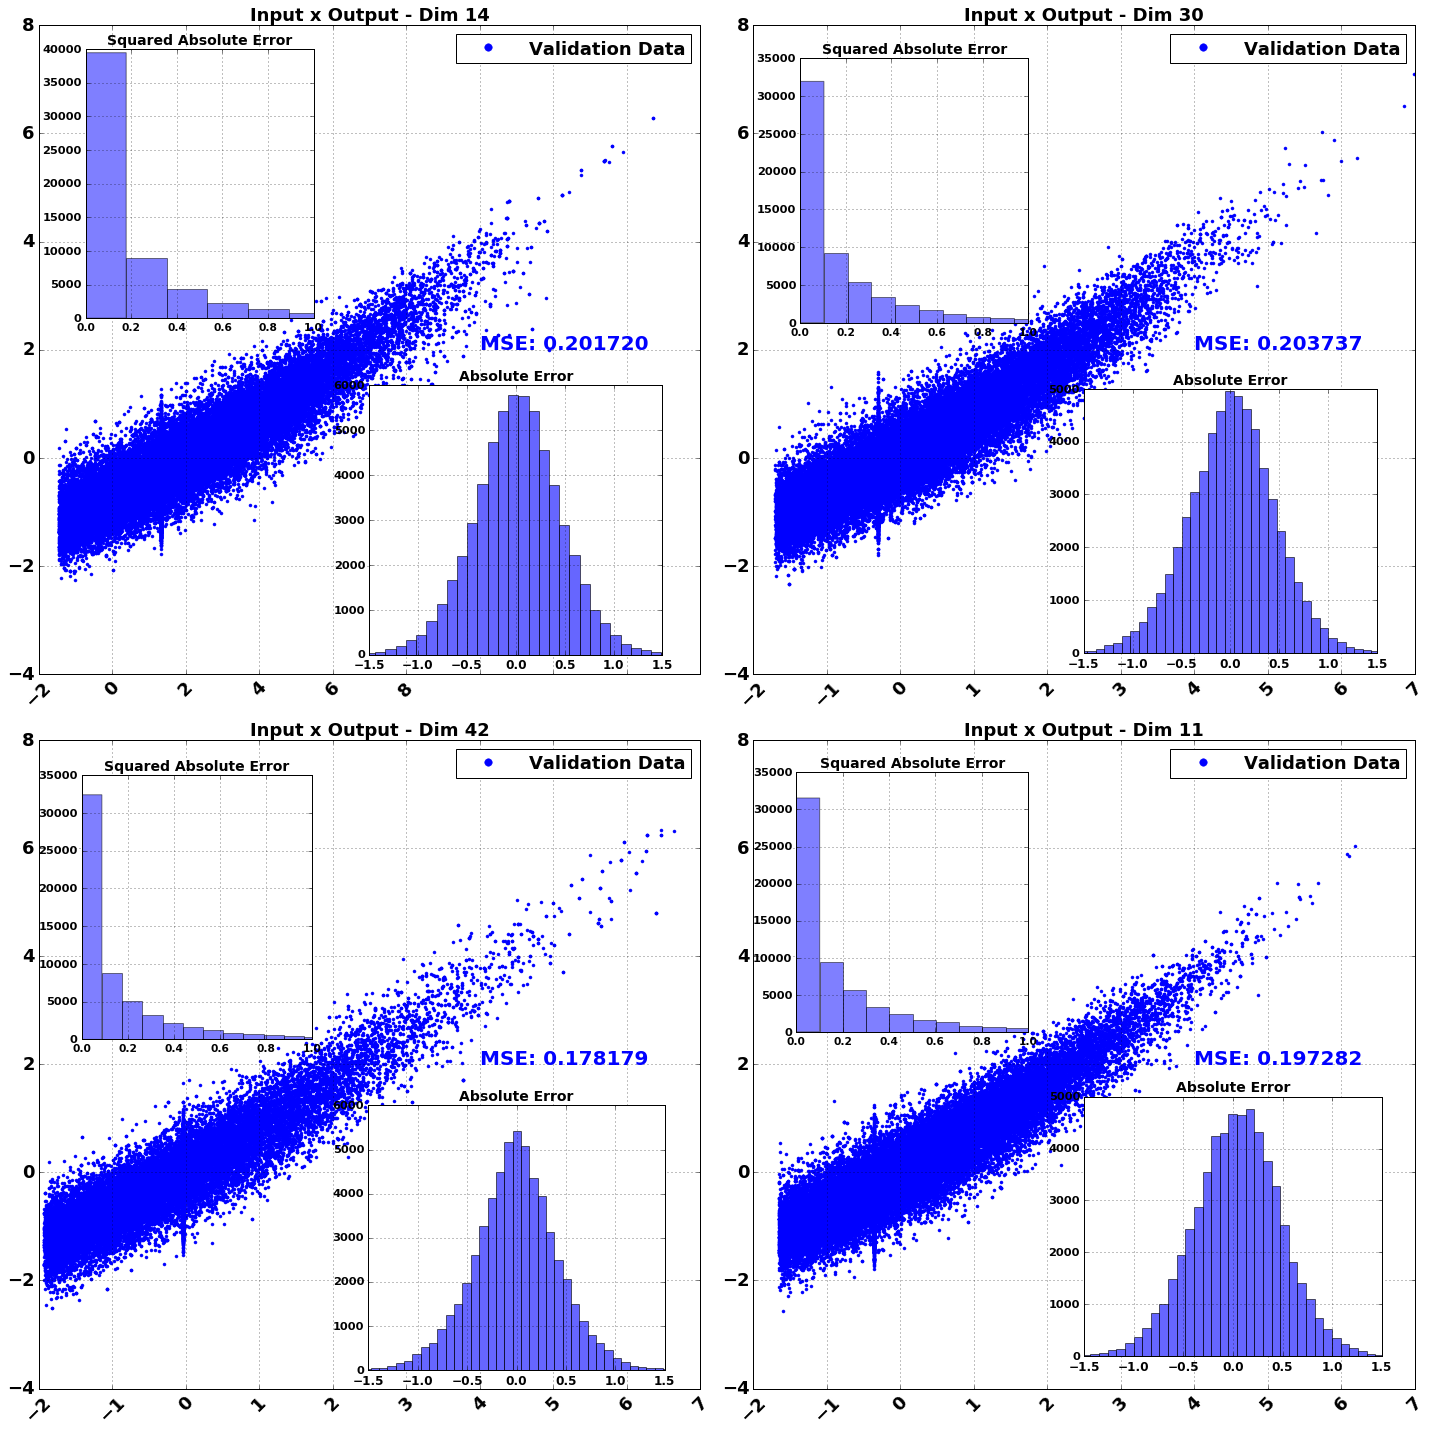

In [47]:
# Analysis of Reconstruction Input x Output

import matplotlib.pyplot as plt
%matplotlib inline  

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'

current_analysis = 'reconstruction_inputxoutput'

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 18
m_colors = ['b', 'r', 'g', 'y']

# Topology
hidden_neurons = [400, 350, 300, 250]

neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
    
models = {}
outputs = {}
mean = {}
indexes = {}

# Load Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)

if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='relu',
                                                         output_activation='linear',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()

for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data)
    norm_data = norm_data[test_id,:]
    
    if ifold == 0:
        diffSquared = np.zeros([len(CVO),norm_data.shape[0],norm_data.shape[1]])
     
    print '[*] Loading topology %s for fold %i'%(neurons_str, ifold)
    # First Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the first layer weights
    first_layer_model = load_model(file_name)
    encoder_first_layer = first_layer_model.layers[0].get_weights()
    decoder_first_layer = first_layer_model.layers[2].get_weights()
    
    # Second Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the second layer projection of data
    second_layer_model = load_model(file_name)
    encoder_second_layer = second_layer_model.layers[0].get_weights()
    decoder_second_layer = second_layer_model.layers[2].get_weights()
    
    # Third Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1],
                                                            hidden_neurons[2])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the third layer projection of data
    third_layer_model = load_model(file_name)
    encoder_third_layer = third_layer_model.layers[0].get_weights()
    decoder_third_layer = third_layer_model.layers[2].get_weights()
    
    # Fourth Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%ix%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1],
                                                            hidden_neurons[2], hidden_neurons[3])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the fourth layer projection of data
    fourth_layer_model = load_model(file_name)
    encoder_fourth_layer = fourth_layer_model.layers[0].get_weights()
    decoder_fourth_layer = fourth_layer_model.layers[2].get_weights()
    #third_layer_model.summary()
    
    model = Sequential()
    # Encoder
    model.add(Dense(hidden_neurons[0], input_dim=norm_data.shape[1], weights=encoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    model.add(Dense(hidden_neurons[1], weights=encoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    model.add(Dense(hidden_neurons[2], weights=encoder_third_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    model.add(Dense(hidden_neurons[3], weights=encoder_fourth_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    # Decoder
    model.add(Dense(hidden_neurons[2], weights=decoder_fourth_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    
    model.add(Dense(hidden_neurons[1], weights=decoder_third_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    
    model.add(Dense(hidden_neurons[0], weights=decoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    
    model.add(Dense(norm_data.shape[1], weights=decoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation'], trainable=False))
    #model.summary()
    all_output = model.predict(norm_data)
    
    outputs[ifold] = all_output
    diffSquared[ifold] = np.power((norm_data - outputs[ifold]), 2) 

mean = np.mean(np.mean(diffSquared, axis=0), axis=0)
indexes = np.argsort(mean)[::-1]
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data)
    norm_data = norm_data[test_id,:]
    
    points = norm_data.shape[0]
    # Number of dimensions to analyse (even number is better!)
    num_dim = 4
    fig, m_ax = plt.subplots(figsize=(20,20),nrows=2, ncols=2)
    for choose_index in range(num_dim):
        ax = plt.subplot(2,2,choose_index+1)
        ax.plot(norm_data[:,indexes[choose_index]][0],
                outputs[ifold][:,indexes[choose_index]][0],
                "b.", label='Validation Data', markersize=15)
        ax.plot(norm_data[:,indexes[choose_index]][:points], 
                outputs[ifold][:,indexes[choose_index]][:points],
                "b.")
        
        plt.tight_layout()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title('Input x Output - Dim %i'%(indexes[choose_index]),fontsize=18, fontweight='bold')  
        ax.set_xlim(-2, 7)
        ax.set_ylim(-4, 8)
        handles, labels = ax.get_legend_handles_labels()
        plt.legend()
        plt.grid()    
        
        # Small plot
        rect = [0.065, 0.55, 0.35, 0.4]
        ax1 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
        
        eq_reconstruction = np.power((norm_data[:,indexes[choose_index]] - outputs[ifold][:,indexes[choose_index]]), 2)

        mq_bins = np.linspace(np.min(eq_reconstruction), np.max(eq_reconstruction), 50)
  
        n, bins, patches = ax1.hist(eq_reconstruction,bins=mq_bins,
                                    fc="b",
                                    alpha=0.5, normed=0)
        ax1.set_xlim(0, 1)
        ax1.set_title("Squared Absolute Error",fontsize=14, fontweight='bold')
        ax1.grid() 
        
        # Small plot
        rect = [0.5, 0.05, 0.45, 0.4]
        ax2 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
        
        e_reconstruction = (norm_data[:,indexes[choose_index]] - outputs[ifold][:,indexes[choose_index]])

        m_bins = np.linspace(np.min(e_reconstruction), np.max(e_reconstruction), 50)
     
        n, bins, patches = ax2.hist(e_reconstruction,bins=m_bins,
                                    fc="b",
                                    alpha=0.6, normed=0)
        ax2.grid()
        ax2.set_title("Absolute Error",fontsize=14, fontweight='bold')
        ax2.set_xlim(-1.5,1.5) 
        
        ax.legend(handles, labels, ncol=1, loc='upper right')
        plt.legend()
        
        mse = metrics.mean_squared_error(norm_data[:,indexes[choose_index]], outputs[ifold][:,indexes[choose_index]])
        ax.text(4, 2, 'MSE: %f'%mse, style='normal',fontsize=20, color='blue',
        bbox={'alpha':0.0, 'pad':10})
        
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_fourth_layer_%s_neurons_%i_fold_'%(neurons_str,ifold)+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)
print "Topology (%s)"%trn_params.get_params_str()

# Análise LOFAR reconstrução da 4ª Camada

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

# LOFARGram for reconstructed input
current_analysis = 'LOFARGram_reconstruction_third_layer'

# Choose num of neurons
hidden_neurons = [400, 300, 200, 100]

# Create a string like InputDimension x FirstLayerDimension x ... x OutputDimension
neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
neurons_str = neurons_str + 'x' + str(all_data.shape[1])

for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data) 
    
    # First Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the first layer weights
    first_layer_model = load_model(file_name)
    encoder_first_layer = first_layer_model.layers[0].get_weights()
    decoder_first_layer = first_layer_model.layers[2].get_weights()
    #first_layer_model.summary()
    
    # Second Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the second layer projection of data
    second_layer_model = load_model(file_name)
    encoder_second_layer = second_layer_model.layers[0].get_weights()
    decoder_second_layer = second_layer_model.layers[2].get_weights()
    #second_layer_model.summary()
    
    # Third Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1],
                                                            hidden_neurons[2])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the third layer projection of data
    third_layer_model = load_model(file_name)
    encoder_third_layer = third_layer_model.layers[0].get_weights()
    decoder_third_layer = third_layer_model.layers[2].get_weights()
    #third_layer_model.summary()
    
    # Fourth Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%ix%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1],
                                                            hidden_neurons[2], hidden_neurons[3])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the fourth layer projection of data
    fourth_layer_model = load_model(file_name)
    encoder_fourth_layer = fourth_layer_model.layers[0].get_weights()
    decoder_fourth_layer = fourth_layer_model.layers[2].get_weights()
    #third_layer_model.summary()
    
    model = Sequential()
    # Encoder
    model.add(Dense(hidden_neurons[0], input_dim=norm_data.shape[1], weights=encoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    model.add(Dense(hidden_neurons[1], weights=encoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    model.add(Dense(hidden_neurons[2], weights=encoder_third_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    model.add(Dense(hidden_neurons[3], weights=encoder_fourth_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    # Decoder
    model.add(Dense(hidden_neurons[2], weights=decoder_fourth_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    
    model.add(Dense(hidden_neurons[1], weights=decoder_third_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    
    model.add(Dense(hidden_neurons[0], weights=decoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    
    model.add(Dense(norm_data.shape[1], weights=decoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation'], trainable=False))
    #model.summary()
    all_output = model.predict(norm_data)
    
    m_fontsize = 15

    fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,10))
    for iclass, class_label in enumerate(class_labels):
        ax = plt.subplot(2,2,iclass+1)
        plt.title('Lofar Analysis for Class %s'%(class_label), fontsize= m_fontsize, fontweight="bold")

        if iclass > 1:
            plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
        if ((iclass == 0) or (iclass==2)):
            plt.ylabel('Time (seconds)', fontsize= m_fontsize, fontweight="bold")

        plt.imshow(all_output[all_trgt==iclass,:],
               cmap="jet",extent=[1, 400, all_output[all_trgt==iclass,:].shape[0],1],
               aspect="auto")
        plt.xticks(np.linspace(0,400,9),rotation=45)
        cbar = plt.colorbar()
        plt.clim(-2,9)
        #if ((iclass == 1) or (iclass==3)):
        cbar.ax.set_ylabel('dB',fontweight='bold') 
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_%s'%neurons_str+'_%i'%ifold+'_fold'+'_'+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)

[*] Loading fold 0
[*] Loading fold 1


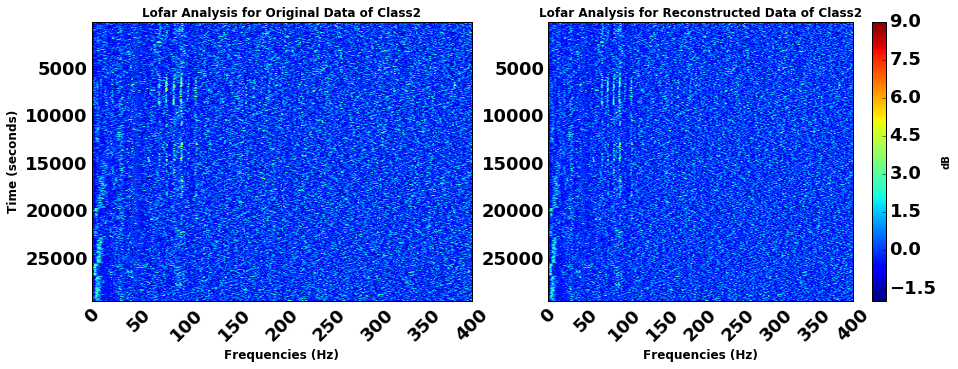

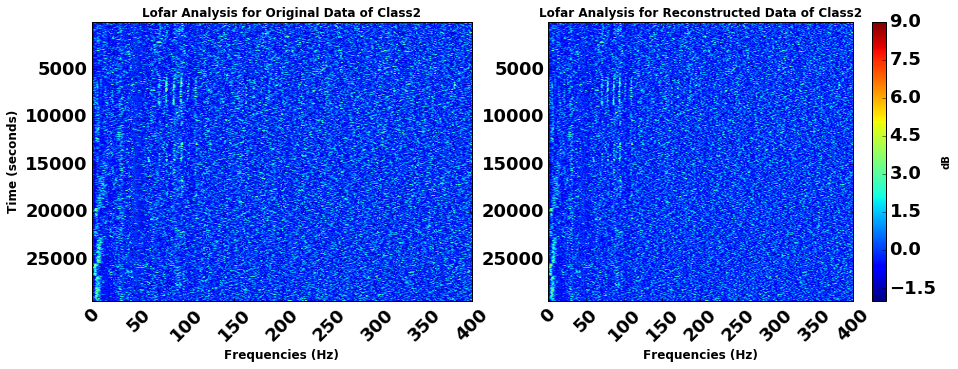

In [38]:
# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

# LOFARGram for reconstructed input with lines
current_analysis = 'LOFARGram_reconstruction_x_original_fourth_layer'

# Choose num of neurons
hidden_neurons = [400, 350, 300, 250]

neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)

# Choose class
iclass = 1

for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data)    
    
    # First Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the first layer weights
    first_layer_model = load_model(file_name)
    encoder_first_layer = first_layer_model.layers[0].get_weights()
    decoder_first_layer = first_layer_model.layers[2].get_weights()
    
    # Second Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the second layer projection of data
    second_layer_model = load_model(file_name)
    encoder_second_layer = second_layer_model.layers[0].get_weights()
    decoder_second_layer = second_layer_model.layers[2].get_weights()
    
    
    # Third Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1],
                                                            hidden_neurons[2])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the third layer projection of data
    third_layer_model = load_model(file_name)
    encoder_third_layer = third_layer_model.layers[0].get_weights()
    decoder_third_layer = third_layer_model.layers[2].get_weights()
    
    # Fourth Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%ix%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1],
                                                            hidden_neurons[2], hidden_neurons[3])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the fourth layer projection of data
    fourth_layer_model = load_model(file_name)
    encoder_fourth_layer = fourth_layer_model.layers[0].get_weights()
    decoder_fourth_layer = fourth_layer_model.layers[2].get_weights()
    #third_layer_model.summary()
    
    model = Sequential()
    # Encoder
    model.add(Dense(hidden_neurons[0], input_dim=norm_data.shape[1], weights=encoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    model.add(Dense(hidden_neurons[1], weights=encoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    model.add(Dense(hidden_neurons[2], weights=encoder_third_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    model.add(Dense(hidden_neurons[3], weights=encoder_fourth_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    # Decoder
    model.add(Dense(hidden_neurons[2], weights=decoder_fourth_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    
    model.add(Dense(hidden_neurons[1], weights=decoder_third_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    
    model.add(Dense(hidden_neurons[0], weights=decoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    
    model.add(Dense(norm_data.shape[1], weights=decoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation'], trainable=False))
    all_output = model.predict(norm_data)
    print '[*] Loading fold %i'%ifold
    m_fontsize = 12

    fig, subplot_array = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
    for i in range(2):
        ax = plt.subplot(1,2,i+1)
        if i == 0:
            plt.ylabel('Time (seconds)', fontsize= m_fontsize, fontweight="bold")
            plt.imshow(norm_data[all_trgt==iclass,:],
               cmap="jet",extent=[1, 400, norm_data[all_trgt==iclass,:].shape[0],1],
               aspect="auto")
            plt.title('Lofar Analysis for Original Data of %s'%(class_labels[iclass]), fontsize= m_fontsize, fontweight="bold")
        if (i == 1):
            plt.imshow(all_output[all_trgt==iclass,:],
               cmap="jet",extent=[1, 400, all_output[all_trgt==iclass,:].shape[0],1],
               aspect="auto")
            plt.title('Lofar Analysis for Reconstructed Data of %s'%(class_labels[iclass]), fontsize= m_fontsize, fontweight="bold")
        plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
        plt.xticks(np.linspace(0,400,9),rotation=45)
        if i == 1:
            cbar = plt.colorbar()
            cbar.ax.set_ylabel('dB',fontweight='bold') 
        plt.clim(-2,9)
        #if ((iclass == 1) or (iclass==3)):
        cbar.ax.set_ylabel('dB',fontweight='bold') 
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_%i'%ifold+'_fold'+'_%s'%neurons_str+'_neurons_%i_class_'%(1+iclass)+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)

# Treinamento de Classificação - 4ª Camada


In [7]:
def SAEClassificationtrainFold(ifold):
    return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                          trgt=all_trgt,
                                          ifold=ifold,
                                          n_folds=n_folds, 
                                          hidden_neurons=(400,300,200,100),
                                          trn_params=trn_params, 
                                          save_path=results_path,
                                          dev=development_flag)

In [8]:
%time

p = multiprocessing.Pool(processes=num_processes)
start_time = time.time()

folds = range(len(CVO))
# To train on multiple cores sweeping the number of folds
results = p.map(SAEClassificationtrainFold, folds)

# To train on multiple cores sweeping the number of neurons
#results = p.map(trainNeuron, neurons)

p.close()
p.join()

end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
Fold 2 of 2 Folds -  Init 1 of 1 Inits
Fold 1 of 2 Folds -  Init 1 of 1 Inits
It took 4590.673 seconds to perform the training


# Análise de Classificação - 4ª Camada

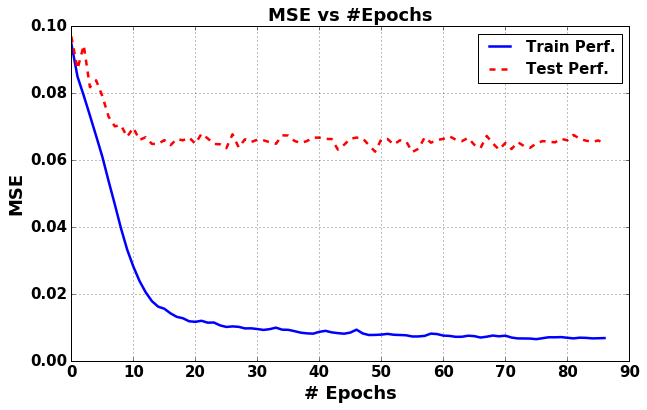

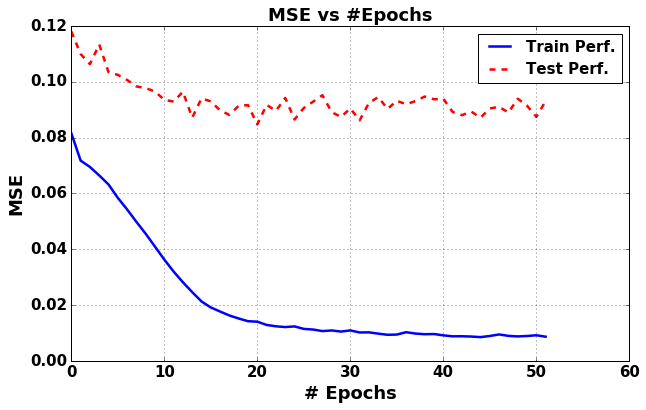

In [11]:
# Mean Squared Error x Epochs
%matplotlib inline  
import matplotlib.pyplot as plt

current_analysis = 'mse'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

hidden_neurons = [400,350,300,250]

# Parameters
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()

# plot train updates
for ifold in range(len(CVO)):
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    plt.rc('legend',**{'fontsize':15})
    plt.rc('font', weight='bold')
    
    fig1 = plt.figure(figsize=(10,6))
    
    neurons_str = str(all_data.shape[1])
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    model_str = '%s/%s/Classification_(%s)_%s_%i_folds_%s'%(save_path,analysis_str,
                                                            neurons_str,
                                                            prefix_str, n_folds,
                                                            params_str)

    if not development_flag:        
        load_file_name = '%s_fold_%i_trn_desc.jbl'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_trn_desc_dev.jbl'%(model_str,ifold)
        print load_file_name
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    [trn_desc] = joblib.load(load_file_name)

    l1 = plt.plot(trn_desc['epochs'],
                  trn_desc['loss'],color=[0,0,1],
                  linewidth=2.5,linestyle='solid',label='Train Perf.')
    l2 = plt.plot(trn_desc['epochs'],
                  trn_desc['val_loss'],color=[1,0,0],
                  linewidth=2.5,linestyle='dashed',label='Test Perf.')
    cost = ''
    cost = 'MSE'

    plt.grid(True)
    plt.xlabel("# Epochs",fontsize=18,fontweight='bold')
    plt.ylabel(cost,fontsize=18,fontweight='bold')
    plt.title(cost+" vs #Epochs",fontsize=18,fontweight='bold')
    plt.legend()
    #Save the figure
    file_name = pict_results_path+'/Classification_(%s)_'%neurons_str\
        +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)

Topology (Classification_(400x400x300x200x100x4)_RawData_2_folds_1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation)


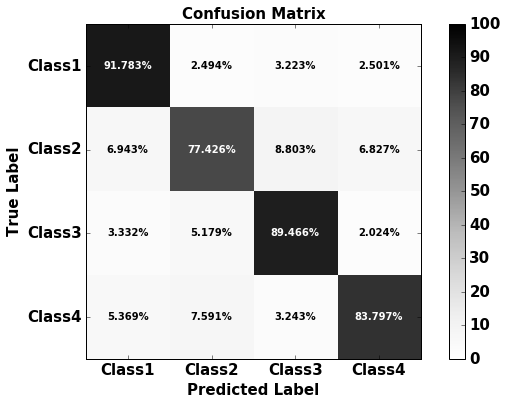

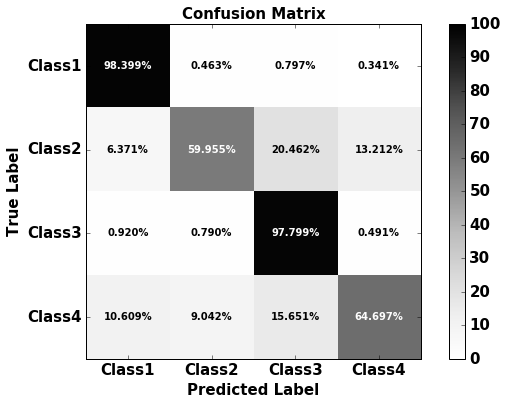

In [12]:
# Confusion Matrix

%matplotlib inline  
from sklearn import preprocessing
import matplotlib.pyplot as plt

current_analysis = 'confusion_matrix'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path


hidden_neurons = [400, 300, 200, 100]
analysis_full_data = False

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear', # for autoencoders
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.set_aspect(1)

    from sklearn.metrics import confusion_matrix

    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
    
    if analysis_full_data:
        norm_data = scaler.transform(all_data)
        norm_trgt = all_trgt
    else: 
        norm_data = scaler.transform(all_data[test_id, :])
        norm_trgt = all_trgt[test_id]
    
    neurons_str = str(all_data.shape[1])
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
    
    all_output = np.argmax(output,axis=1)
    cm = confusion_matrix(norm_trgt, all_output)
    cm_normalized = 100.*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im =ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

    width, height = cm_normalized.shape

    for x in xrange(width):
        for y in xrange(height):
            if cm_normalized[x][y] < 50.:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center')
            else:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center',color='white')

    ax.set_title('Confusion Matrix',fontweight='bold',fontsize=15)
    fig.colorbar(im)
    tick_marks = np.arange(len(labels))
    ax.xaxis.set_ticks(tick_marks)
    ax.xaxis.set_ticklabels(labels)

    ax.yaxis.set_ticks(tick_marks)
    ax.yaxis.set_ticklabels(labels)

    ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
    ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
    
    #Save the figure
    if analysis_full_data:
        file_name = pict_results_path+'/Classification_(%s)_all_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    else: 
        file_name = pict_results_path+'/Classification_(%s)_test_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print 'Topology (%s)'%topology
if analysis_full_data:
    print 'Analysis in All Data'

In [ ]:
# Histogram

%matplotlib inline  
from sklearn import preprocessing

current_analysis = 'histogram'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

# Choose Topology
hidden_neurons = [400,300,200,100]
analysis_full_data = False

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    if analysis_full_data:
        norm_data = scaler.transform(all_data)
        norm_trgt = all_trgt
    else: 
        norm_data = scaler.transform(all_data[test_id, :])
        norm_trgt = all_trgt[test_id]
    
    neurons_str = str(all_data.shape[1])
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
    # Check if the topology has already been trained    
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   
    from sklearn.neighbors import KernelDensity

    m_bins = np.linspace(-0.5, 1.5, 50)

    m_colors = ['b', 'r', 'g', 'y']
    
    for i_target in range(trgt_sparse[test_id].shape[1]):
        for i_output in range(output.shape[1]):
            subplot_id = output.shape[1]*i_target+i_output
            m_pts = output[norm_trgt==i_target,i_output]

            n, bins, patches = ax[i_target,i_output].hist(m_pts,bins=m_bins,
                                                          fc=m_colors[i_target],
                                                          alpha=0.8, normed=0)

            if i_output == 0:
                ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                                 fontweight='bold',fontsize=15)
            if i_target == 3:
                ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                                 fontweight='bold',fontsize=15)
            ax[i_target,i_output].grid()
    
    #Save the figure
    if analysis_full_data:
        file_name = pict_results_path+'/Classification_(%s)_all_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    else: 
        file_name = pict_results_path+'/Classification_(%s)_test_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print 'Topology (%s)'%topology
if analysis_full_data:
    print 'Analysis in All Data'

In [ ]:
# Kernel Density

%matplotlib inline  
from sklearn import preprocessing
import matplotlib.pyplot as plt

current_analysis = 'kernel_density'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

# Choose Topology
hidden_neurons = [400,300,200,100]
analysis_full_data = False

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    if analysis_full_data:
        norm_data = scaler.transform(all_data)
        norm_trgt = all_trgt
    else: 
        norm_data = scaler.transform(all_data[test_id, :])
        norm_trgt = all_trgt[test_id]
    
    neurons_str = str(all_data.shape[1])
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name 
    # Check if the topology has already been trained    
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   
    from sklearn.neighbors import KernelDensity

    m_bins = np.linspace(-0.5, 1.5,100)

    m_colors = ['b', 'r', 'g', 'y']

    kernel = 'gaussian' # other kernels: 'gaussian', 'tophat', 
                        #'epanechnikov', 'exponential', 'linear', 'cosine'
    for i_target in range(trgt_sparse[test_id].shape[1]):
        for i_output in range(output.shape[1]):
            subplot_id = output.shape[1]*i_target+i_output
            m_pts = output[norm_trgt==i_target,i_output]

            kde = KernelDensity(kernel=kernel,algorithm='auto',
                                bandwidth=0.5).fit(m_pts[:, np.newaxis])
            log_dens_x = kde.score_samples(m_bins[:, np.newaxis])
            ax[i_target,i_output].plot(m_bins, np.exp(log_dens_x),
                                       color=m_colors[i_target],linewidth=2.0)
            if i_output == 0:
                ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                                 fontweight='bold',fontsize=15)
            if i_target == 3:
                ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                                 fontweight='bold',fontsize=15)
            ax[i_target,i_output].grid()
    
    #Save the figure
    if analysis_full_data:
        file_name = pict_results_path+'/Classification_(%s)_all_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    else: 
        file_name = pict_results_path+'/Classification_(%s)_test_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print 'Topology (%s)'%topology
if analysis_full_data:
    print 'Analysis in All Data'

In [48]:
# Classification Report

current_analysis = 'report'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

# Choose Topology
hidden_neurons = [400,300,200,100]
analysis_full_data = False

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)
params_str = trn_params.get_params_str()

neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])

print "Results for (%s) neurons (%s)"%(neurons_str, params_str)
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data[test_id,:])
    
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name
    # Check if the topology has already been trained    
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   
    num_classes = len(class_labels.keys())
    
    efficiency = metrics.recall_score(trgt_sparse[test_id], np.round(output), average=None)
    sp_index = np.sum(efficiency)/num_classes * np.power(np.prod(efficiency), 1/num_classes)
    sp_index = np.sqrt(sp_index)
    
    precision = metrics.precision_score(trgt_sparse[test_id], np.round(output), average=None)
    f1_score = metrics.f1_score(trgt_sparse[test_id], np.round(output), average=None)
    print '\tPrecision\tEfficiency\tF1_Score'
    for iclass in range(num_classes):
        print '%s:\t%f\t%f\t%f\n'%(class_labels[iclass], precision[iclass], efficiency[iclass],f1_score[iclass])
    print 'SP index: %f\n'%sp_index
   

Results for (400x400x300x200x100x4) neurons (1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation)
	Precision	Efficiency	F1_Score
Class1:	0.866973	0.911693	0.888771

Class2:	0.835330	0.774257	0.803635

Class3:	0.854206	0.894658	0.873964

Class4:	0.880693	0.837967	0.858799

SP index: 0.924469

	Precision	Efficiency	F1_Score
Class1:	0.862028	0.982557	0.918354

Class2:	0.853443	0.599550	0.704314

Class3:	0.725999	0.977991	0.833362

Class4:	0.821651	0.646975	0.723925

SP index: 0.895415

